# Getting Started with Readout Error Mitigation with mitiq on Braket 

In this notebook, you will learn how to perform readout-error mitigation using mitiq with Amazon Braket ProgramSets. This is particularly helpful for superconducting devices, which may contain larger measurement errors. We also consider post-selection, which can be carried out using mitiq. 

### Installing mitiq
>[!WARNING]
>mitiq is distributed under the GPL GNU v3 license, and so is not included by default with `amazon-braket-examples` requirements or in the Amazon Braket Notebook Instances. To install, uncomment the first line in the next code block, and restart the notebook. 

Mitiq utilizes Cirq as the backend, and may represent circuits using their representation. 

In [ ]:
# !pip install mitiq

try:
    import mitiq
    print("Package 'mitiq' is installed.")
except ImportError:
    print("!! Package 'mitiq' is not installed !!")


Package 'mitiq' is installed.


In [2]:
from braket.circuits import Circuit
from qiskit_braket_provider import to_braket, to_qiskit
import numpy as np
np.set_printoptions(linewidth=500, precision=3, suppress=True)
from noise_models import qd_readout as qd
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="qiskit_braket_provider")

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir))) # parent  
from tools.mitigation_tools import apply_readout_twirl
from noise_models import qd_readout_2 as qd2

### Readout Error Mitigation

Readout errors, occur largely due to challenges in performing projective or POVM measurements on a device, which heavily depend on the particular hardware used and relevant physics or timescales. Readout error mitigation, or REM, specifically focuses on corecting these errors. Because of the ubiquity of the problem and the prevelance of superconducting devices, many schemes historically have focused on SC devices. However, different mitigation schemes may be better suited for particular device types, which some architectures havingvery high readout fidelities. 

Regardless of the device, for static circuits (i.e. a traditional circuit model), we only need to measure once, and thus even largely high readout error rates can be permitted at the cost of a constant shot overhead. This is generally applicable to state preparation errors as well, though we may not consider these as much. 

The most common way of performing readout error mitigation is to (1) characterize the confusion matrix $C$ of relevant input state and output states, (2) calculate the inverse of this matrix, $C^{-1}$ and then (3) apply the inverse to your measurement results (which w.l.o.g. can be cast as an array) to obtain some error mitigated results. Each of these steps can involve some technical challenges at scale, which we detail below. 

An optional step, which is utilzied in mitiq, is to (4) constrain the modified distribution to the closest probability distribution, using `scipy`.  

##### Note on Post-Selection

Note, we can equivalently cast $C$ as some projector $C_P$, where $P$ is a set of bit-strings that obey particlary symmetries. $C$ is not invertible, but we can still consider it as a sort of filter applied to measurement results. mitiq does support post selection as well. 


#### Import the relevant mitiq functions


In [3]:
from mitiq.rem import generate_tensored_inverse_confusion_matrix, generate_inverse_confusion_matrix, rem_decorator, post_select, mitigate_measurements
from mitiq import MeasurementResult

#### Get the Confusion Matrix

The confusion matrix can be obtained by preparing a complete set of input states and performing measurement in each basis. This in principle yields the following transition probabilities $C_{oi} = P(o | i)$, where $P(o | i)$ is the conditional probabilities of measuring a state $o$ when preparing $i$. For our purposes, we will have to learn our confusion matrix ourselves, so we do so here: 

In [4]:
# let's get a 6-qubit local readout 

results = []
shots = []

for i in range(2**6):
    circ = Circuit()
    bstr = f"{i:06b}"

    for n,b in enumerate(bstr):
        circ.x(n) if b=="1" else circ.i(n)

    circ = to_braket(to_qiskit(circ, add_measurements=False), 
                     basis_gates = ["r", "cz","barrier", "measure"])
    results.append(qd.run(circ.measure(range(6)),shots=10000).result().measurement_probabilities)

print(circ) # final state should be all X 



T  : │         0         │  1  │
      ┌─────────────────┐ ┌───┐ 
q0 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q1 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q2 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q3 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q4 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q5 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
T  : │         0         │  1  │


We then populate the confusion matrix in the variable `cm`, which is output below. 

In [5]:
cm = np.zeros((2**6,2**6))
np.set_printoptions(precision=3,linewidth=400,suppress=True)

for n,meas_results in enumerate(results):
    for k,v in meas_results.items():
        cm[n , int(k,2)] = v

for i in range(64):
    print(cm[:,i])

[0.733 0.04  0.038 0.003 0.039 0.002 0.001 0.    0.044 0.001 0.002 0.    0.002 0.    0.    0.    0.036 0.003 0.002 0.    0.002 0.    0.    0.    0.002 0.    0.    0.    0.    0.    0.    0.    0.038 0.002 0.002 0.    0.002 0.    0.    0.    0.002 0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.039 0.728 0.002 0.038 0.002 0.042 0.    0.002 0.002 0.04  0.    0.002 0.    0.002 0.    0.    0.002 0.039 0.    0.002 0.    0.002 0.    0.    0.    0.002 0.    0.    0.    0.    0.    0.    0.002 0.035 0.    0.002 0.    0.002 0.    0.    0.    0.002 0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.041 0.002 0.736 0.041 0.001 0.    0.04  0.002 0.002 0.    0.039 0.002 0.    0.    0.003 0.    0.002 0.    0.041 0.002 0.    0.    0.002 0.    0.    0.    0.002 0.    0.    0.    0.    0.    0.002 0.    0.042 0.002 0.    0.   

In [6]:
cm_i = generate_tensored_inverse_confusion_matrix(6, confusion_matrices=[cm])

Having the inverse confusion matrix, we can then apply this to our circuits.

In [7]:

circ = Circuit().h(0).cnot(0,1).cnot(1,2).cnot(2,3).cnot(3,4).cnot(4,5).measure(range(6))
circ = to_braket(to_qiskit(circ, add_measurements=False), 
                    basis_gates = ["r", "cz","barrier", "measure"])
# 

raw_results = []

@rem_decorator(inverse_confusion_matrix=cm_i)
def GHZ_res(circ):
    counts = qd.run(circ, shots = 10000).result().measurement_counts
    raw_results.append(counts)
    return MeasurementResult.from_counts(counts)

res = GHZ_res(circ).get_counts()


We can alternatively filter our results using post-selection.

In [8]:
def GHZ_res(circ):
    counts = qd.run(circ, shots = 10000).result().measurement_counts
    raw_results.append(counts)
    return MeasurementResult.from_counts(counts)

ps_res = post_select(GHZ_res(circ), lambda bits: all(bits) or all([not b for b in bits])).get_counts()
print(ps_res)


{'111111': 3638, '000000': 3679}


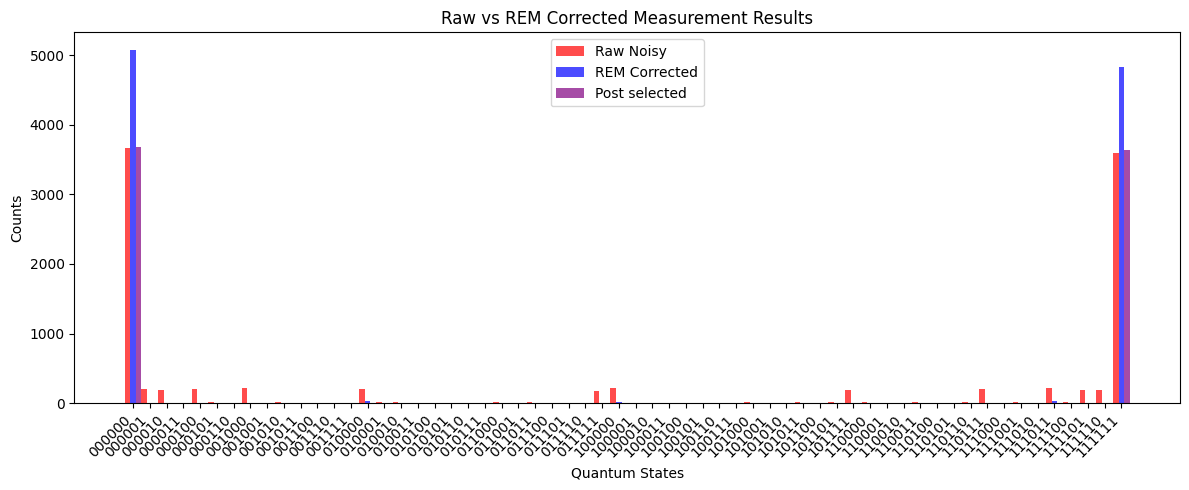

In [9]:
import matplotlib.pyplot as plt

raw_counts = raw_results[0]
corrected_counts = res

all_states = sorted(set(raw_counts.keys()) | set(corrected_counts.keys()))
raw_values = [raw_counts.get(state, 0) for state in all_states]
corr_values = [corrected_counts.get(state, 0) for state in all_states]
ps_values = [ps_res.get(state, 0) for state in all_states]


plt.figure(figsize=(12,5))
x = range(len(all_states))
width = 0.333
plt.bar([i - width for i in x], raw_values, width, label='Raw Noisy', color='red', alpha=0.7)
plt.bar([i  for i in x], corr_values, width, label='REM Corrected', color='blue', alpha=0.7)
plt.bar([i + width for i in x], ps_values, width, label='Post selected', color='purple', alpha=0.7)
plt.xlabel('Quantum States')
plt.ylabel('Counts')
plt.title('Raw vs REM Corrected Measurement Results')
plt.xticks(x, all_states, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

### Addressing Concerns with Cost, Accuracy, and Efficiency

Here, we detail two additional features that we use to improve the above naive execution. 


#### Characterization via ProgramSets

The first task is to replace job submission with ProgramSets. This allows us to submit many more circuits simultaneously. The above characterization circuits for instance, can be submitted with a single ProgramSet.

In [10]:
# let's get a 6-qubit local readout 
from braket.program_sets import ProgramSet

circuits = []
for i in range(2**6):
    circ = Circuit()
    bstr = f"{i:06b}"

    for n,b in enumerate(bstr):
        circ.x(n) if b=="1" else circ.i(n)

    circ = to_braket(to_qiskit(circ, add_measurements=False), 
                     basis_gates = ["r", "cz","barrier", "measure"],qubit_labels=[1,2,6,12,11,5])
    circuits.append(circ.measure(range(6)))

pset = ProgramSet(circuits, shots_per_executable=10000)

result = qd.run(pset).result()
 


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/default_simulator/simulator.py:333: UserWarning: You are running a noise-free circuit on the density matrix simulator. Consider running this circuit on the state vector simulator: LocalSimulator("default") for a better user experience.
  warnings.warn(


The result is to reducing queue times and service overhead time, as well as the total cost by \$0.32 * (64-1) ~ \$19, just from job submission. 

### Simplifying characterization with twirling 

We can further simplify the above procedure somewhat by considering a variant of the readout procedure. **TLDR**, we randomize the output measurement channel, and thus remove our input state dependence, reducing $2^n$ characterizations to 1. 

The measurement POVM in the computational basis can be written as $M_i = \frac{1}{2}(I_i \pm Z_i)$. The measurement channel itself has the form $\mathcal{E}[\rho] = M_0 \rho M_0 + M_1 \rho M_1$. We can effectively "twirl" the measurement operation by inserting Pauli gates before (physically) and after (virtually). For a measurement channel, this will yield an effective bitflip channel.

The main difference here is the cost of learning - in a single configuration we can now learn all the symmetrized transition coeffieints to precision $1/\sqrt{N}$. Another way to think of this is that most states have similar transition rates from 0 to 1 and 1 to 0. If we randomly flip these for all states, then we effectively average it out so that in practice they ***are** all the same. 


#### Executing with Braket

We use a built-in function, `tools/apply_readout_twirl`, which generates the random twirled permutations and keeps track of the Pauli twirls associated it with. 

In [11]:

circuit = Circuit().z(0).z(1).z(2).z(3)

variants, paulis = apply_readout_twirl(circuit, num_samples = 5)

print(variants[-1])
print(paulis)


T  : │  0  │  1  │
      ┌───┐ ┌───┐ 
q0 : ─┤ Z ├─┤ Z ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q1 : ─┤ Z ├─┤ Z ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q2 : ─┤ Z ├─┤ X ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q3 : ─┤ Z ├─┤ Y ├─
      └───┘ └───┘ 
T  : │  0  │  1  │
('YZYI', 'XZXZ', 'XYXX', 'XIII', 'ZZXY')


Now, let's see how performing twirls can standardize our distribution. Using $10^7$ shots, we look at $N_{twirls} = 10^m$ for $m \in \{1,2,3,4,5\}$. We can see that for $Z$ measurements, we can simply apply the Pauli as a bit mask using bit addition to get the "correct" measurement result. 

In [12]:
n_twirls = [1,10,100,1000,10000]

circuit = Circuit()
for i in range(6):
    circuit.z(i)


distributions = []
for n in n_twirls:
    variants, masks  = apply_readout_twirl(circuit, n)
    variants = [qd2._noise_model.apply(v.measure(range(6))) for v in variants]
    masks = [''.join('1' if s in ["X","Y"] else '0' for s in m) for m in masks]

    pset = ProgramSet(variants, shots_per_executable= 1000000//n)
    results = qd2.run(pset).result()

    base = {}
    for item, mask in zip(results, masks):
        for k, v in item.entries[0].probabilities.items():
            kp = ''.join(str(int(a) ^ int(b)) for a, b in zip(k, mask))
            base[kp] = base.get(kp, 0) + v

    # Normalize
    base = {k: v/n for k, v in base.items()}

    distributions.append(base)
    print(f"Distribution from twirling with {n} different measurement bases:")
    print(base)



Distribution from twirling with 1 different measurement bases:
{'000001': 0.071554, '010000': 0.041029, '000000': 0.696457, '000100': 0.032035, '100000': 0.043845, '101000': 0.002243, '001000': 0.036932, '100100': 0.001998, '100001': 0.004499, '000101': 0.003371, '000110': 0.001612, '000010': 0.035163, '010001': 0.004192, '010100': 0.001848, '001100': 0.001664, '011010': 0.000111, '110000': 0.002712, '000011': 0.003576, '011000': 0.00217, '100010': 0.002205, '000111': 0.000155, '001001': 0.003761, '101100': 0.000104, '001010': 0.001785, '010010': 0.00209, '101010': 9.9e-05, '110001': 0.000232, '011001': 0.000235, '100011': 0.00023, '100101': 0.000228, '110100': 0.000116, '001011': 0.000182, '110010': 0.000106, '011100': 8.7e-05, '010110': 0.000108, '100110': 0.000115, '001101': 0.000182, '101001': 0.000243, '010011': 0.00021, '110110': 1.1e-05, '011101': 5e-06, '101011': 8e-06, '010101': 0.000192, '011011': 7e-06, '111101': 1e-06, '001110': 7.1e-05, '111000': 0.000115, '001111': 7e-06,

Now, taking the 10000 twirls result as the population mean, we can look at the distribution of errors for different $n$:

[{'000001': 0.071554, '010000': 0.041029, '000000': 0.696457, '000100': 0.032035, '100000': 0.043845, '101000': 0.002243, '001000': 0.036932, '100100': 0.001998, '100001': 0.004499, '000101': 0.003371, '000110': 0.001612, '000010': 0.035163, '010001': 0.004192, '010100': 0.001848, '001100': 0.001664, '011010': 0.000111, '110000': 0.002712, '000011': 0.003576, '011000': 0.00217, '100010': 0.002205, '000111': 0.000155, '001001': 0.003761, '101100': 0.000104, '001010': 0.001785, '010010': 0.00209, '101010': 9.9e-05, '110001': 0.000232, '011001': 0.000235, '100011': 0.00023, '100101': 0.000228, '110100': 0.000116, '001011': 0.000182, '110010': 0.000106, '011100': 8.7e-05, '010110': 0.000108, '100110': 0.000115, '001101': 0.000182, '101001': 0.000243, '010011': 0.00021, '110110': 1.1e-05, '011101': 5e-06, '101011': 8e-06, '010101': 0.000192, '011011': 7e-06, '111101': 1e-06, '001110': 7.1e-05, '111000': 0.000115, '001111': 7e-06, '111100': 1.4e-05, '110101': 1.3e-05, '111001': 1.7e-05, '111

/var/folders/1_/bfh8x9qn75164y0b808mvhrh0000gq/T/ipykernel_46853/145884285.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


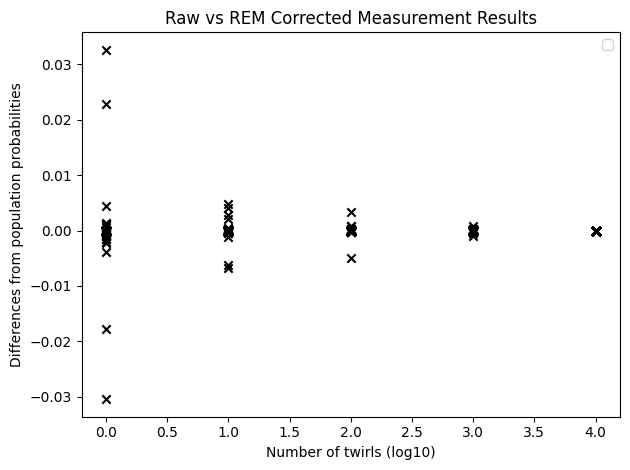

In [13]:
import matplotlib.pyplot as plt

print(distributions)
raw_counts = raw_results[0]
corrected_counts = res

bars = [f"{k:06b}" for k in range(2**6)]

data = np.array([[distributions[i].get(state, 0) for state in bars] for i in range(len(distributions))])
data = data - data[-1,:] # broadcast the final entries 
data = data[:,:]
plt.figure()
# for i in range(len(distributions)-1):
for i in range(len(bars)):
    plt.scatter(range(len(distributions)), data[:,i], c= 'k', marker ='x')
    # plt.hist(data[i,:], bins = 50)
plt.xlabel('Number of twirls (log10)')
plt.ylabel('Differences from population probabilities')
plt.title('Raw vs REM Corrected Measurement Results')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
for i,n in enumerate(n_twirls[:-1]):    
    errors = data[:,i]
    print(f"errors (from largest result) across 10^{int(np.log10(n))} twirl(s): {np.average(errors):+.3f} +/- {np.std(errors):.3f}")

errors (from largest result) across 10^0 twirl(s): +0.007 +/- 0.013
errors (from largest result) across 10^1 twirl(s): +0.004 +/- 0.010
errors (from largest result) across 10^2 twirl(s): +0.000 +/- 0.000
errors (from largest result) across 10^3 twirl(s): +0.000 +/- 0.000


This distribution will look different for various noise models and realistic devices (in particular, symmetric noise would be a constant). Here we can see that the amplitude damping noise, which biases the measurement result towards a particular state, is effectively mitigated. 

When considering the precision, we see that even 10 twirls well approximates the mean, and at 100 twirls our standard deviations is below our expected sampling threshold of 0.001. 

#### Applying Twirls Results

Now, taking the 100-twirled result as our baseline, we can use this distribution to inform our noise model. Let's take 10000 shots with 100 twirls, targetting a noise precision of 0.01. 



In [96]:
total_shots = 4096
total_twirls = 64

circuit = Circuit()
for i in range(6):
    circuit.z(i)

distributions = []
variants, masks  = apply_readout_twirl(circuit, total_twirls)
masks = [''.join('1' if s in ["X","Y"] else '0' for s in m) for m in masks]
variants = [qd2._noise_model.apply(v.measure(range(6))) for v in variants]

# form program set

pset = ProgramSet(variants, shots_per_executable= total_shots//total_twirls)
results = qd2.run(pset).result()

base = {}
for item, mask in zip(results, masks):
    for k, v in item.entries[0].probabilities.items():
        kp = ''.join(str(int(a) ^ int(b)) for a, b in zip(k, mask))
        base[kp] = base.get(kp, 0) + v

# Normalize
base = {k: v/total_twirls for k, v in base.items()}

distributions.append(base)
print(base)



{'000000': 0.68212890625, '000001': 0.051025390625, '101000': 0.005859375, '001000': 0.051025390625, '100000': 0.06396484375, '010000': 0.041259765625, '001011': 0.000244140625, '100001': 0.00634765625, '000010': 0.033935546875, '000100': 0.0244140625, '110000': 0.005859375, '100101': 0.0009765625, '001010': 0.00341796875, '001100': 0.00439453125, '011000': 0.003173828125, '010001': 0.003173828125, '101001': 0.000244140625, '001111': 0.000244140625, '010101': 0.00048828125, '010010': 0.002197265625, '100100': 0.002197265625, '000011': 0.00244140625, '001001': 0.002685546875, '000110': 0.000732421875, '110001': 0.000244140625, '100110': 0.00048828125, '010100': 0.001220703125, '011100': 0.000244140625, '100010': 0.002197265625, '010011': 0.000244140625, '111001': 0.000244140625, '000101': 0.001708984375, '110010': 0.000244140625, '001101': 0.000244140625, '100011': 0.000244140625, '000111': 0.000244140625}


From this distribution, we can learn marginal distributions by summing over bitstrings. The relevant marginals we are interested are the single qubit bit flip probabilties. 

In [97]:
from functools import reduce 

qubit_tallies = [0,0,0,0,0,0]
for i in range(6):
    for k,v in base.items():
        if k[i] == '1':
            qubit_tallies[i] += v

confusion_matrix = np.array([])

mats = [generate_inverse_confusion_matrix(1,p0=i,p1=i) for i in qubit_tallies]
print("Average single qubit bit flip rates")
print(qubit_tallies)
mat = reduce(np.kron, mats, np.array([[1]]))
print("Tensored inverse confusion matrix: ")
for i in range(64):
    print(mat[:,i])

Average single qubit bit flip rates
[0.089111328125, 0.05859375, 0.072021484375, 0.03759765625, 0.046875, 0.071044921875]
Tensored inverse confusion matrix: 
[ 1.519 -0.116 -0.075  0.006 -0.059  0.005  0.003 -0.    -0.118  0.009  0.006 -0.     0.005 -0.    -0.     0.    -0.095  0.007  0.005 -0.     0.004 -0.    -0.     0.     0.007 -0.001 -0.     0.    -0.     0.     0.    -0.    -0.149  0.011  0.007 -0.001  0.006 -0.    -0.     0.     0.012 -0.001 -0.001  0.    -0.     0.     0.    -0.     0.009 -0.001 -0.     0.    -0.     0.     0.    -0.    -0.001
  0.     0.    -0.     0.    -0.    -0.     0.   ]
[-0.116  1.519  0.006 -0.075  0.005 -0.059 -0.     0.003  0.009 -0.118 -0.     0.006 -0.     0.005  0.    -0.     0.007 -0.095 -0.     0.005 -0.     0.004  0.    -0.    -0.001  0.007  0.    -0.     0.    -0.    -0.     0.     0.011 -0.149 -0.001  0.007 -0.     0.006  0.    -0.    -0.001  0.012  0.    -0.001  0.    -0.    -0.     0.    -0.001  0.009  0.    -0.     0.    -0.    -0.     0.  

#### On the Variance of Measurement Inversion and Post Selection

REM techniques generally affect the variance of othe output distribution.


From [this reference](https://arxiv.org/pdf/2006.14044), we can see that the variance for a tensor product of single qubit probabilities increases the variance by:

$$ \gamma =  \prod_{j=1}^n \frac{1}{1 - 2 p_j}$$

where $p_j$ is the effective bitflip error rate.

Below, we calcuate the $\gamma$ factor for our above single bit-flip model. This implies that we need to increase our shots by a factor of $\gamma^2$ to decrease the precision by $\gamma$.  

In [98]:
gamma = reduce(lambda x,y: x*y,[1/ (1- 2*pi) for pi in qubit_tallies], 1)

print(f"gamma factor: {gamma}")

gamma factor: 2.239677812044068


Let's try to confirm this. Using the 6-qubit result, we can prepare a Hadamard state, and then plot the probability of measure 0.

In [99]:
from mitiq.rem.inverse_confusion_matrix import (
    bitstrings_to_probability_vector, closest_positive_distribution,
    sample_probability_vector
)

def modified_mitigate_measurements(
    noisy_result: MeasurementResult,
    inverse_confusion_matrix,
) -> MeasurementResult:
    """Applies the inverse confusion matrix against the noisy measurement
    result and returns the adjusted measurements.

    Args:
        noisy_results: The unmitigated ``MeasurementResult``.
        inverse_confusion_matrix: The inverse confusion matrix to apply to the
            probability vector estimated with noisy measurement results.

    Returns:
        A mitigated MeasurementResult.
    """
    if not isinstance(noisy_result, MeasurementResult):
        raise TypeError("Result is not of type MeasurementResult.")

    num_qubits = noisy_result.nqubits
    required_shape = (2**num_qubits, 2**num_qubits)
    if inverse_confusion_matrix.shape != required_shape:
        raise ValueError(
            f"Inverse confusion matrix should have shape {required_shape}, but"
            f" it has {inverse_confusion_matrix.shape} instead."
        )

    empirical_prob_dist = bitstrings_to_probability_vector(noisy_result.result)
    adjusted_quasi_dist = (inverse_confusion_matrix @ empirical_prob_dist.T).T
    # positive = adjusted_quasi_dist >= 0
    # negative = adjusted_quasi_dist < 0
    norm = np.sum(np.abs(adjusted_quasi_dist))
    print(norm)
    # adjusted_prob_dist = closest_positive_distribution(adjusted_quasi_dist)
    adjusted_bitstrings = sample_probability_vector(
        np.abs(adjusted_quasi_dist) * (1/norm), noisy_result.shots
    )
    result = MeasurementResult(adjusted_bitstrings, noisy_result.qubit_indices).get_counts()
        
    to_dist = {k:v*(-1)**(adjusted_quasi_dist[int(k,2)]<0) for k,v in result.items()}

    return to_dist


In [114]:
from scipy.stats import bootstrap
from braket.devices import LocalSimulator
from braket.circuits.observables import Z

def apply_rem(circuit : Circuit, shots):
    ideal = LocalSimulator().run(circ + Circuit().expectation(Z(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5)), shots = 0).result().values[0]

    variants, masks  = apply_readout_twirl(circuit, 64)
    masks = [''.join('1' if s in ["X","Y"] else '0' for s in m) for m in masks]
    variants = [qd2._noise_model.apply(v.measure(range(6))) for v in variants]
    # print(variants[-1])
    pset = ProgramSet(variants, shots_per_executable= shots//64)
    print(f"shots_per_executable = {shots//64}")
    results = qd2.run(pset).result()
 
    dist = {}
    evs = []
    for item, mask in zip(results, masks):
        for k, v in item.entries[0].counts.items():
            kp = ''.join(str(int(a) ^ int(b)) for a, b in zip(k, mask))
            dist[kp] = dist.get(kp, 0) + v

    #dist = mitigate_measurements(MeasurementResult.from_counts(dist), inverse_confusion_matrix=mat).get_counts()
    dist = modified_mitigate_measurements(MeasurementResult.from_counts(dist), inverse_confusion_matrix=mat) # .get_counts()
    
    print(dist)
    tally_m1 = 0
    tally_p1 = 0
    for k,v in dist.items():
        if k.count("1") % 2 == 0:
            tally_p1 += v
        else:
            tally_m1 += v
    assert tally_m1 > 1 and tally_p1 > 1, f"negative results: {tally_m1},{tally_p1}"
    vals = [+1] * tally_p1 + [-1] * tally_m1

    # res = bootstrap((vals,), lambda x : np.mean(x))

    noiseless = LocalSimulator().run(circ, shots = shots).result().measurement_counts
    ideal_vals = [(-1)**(k.count("1")) for k,v in noiseless.items() for i in range(v)]
    # res_ideal = bootstrap((ideal_vals,), lambda x : np.mean(x))
    return np.mean(vals), np.mean(ideal_vals)


angle = np.pi/4
circ = Circuit().h(range(6)).ry(range(6),np.pi/4)
circ = Circuit().h(0).cnot(0,1).cnot(1,2).cnot(1,3).ry(3,angle).cnot(3,4).cnot(4,5)
print(circ)
ideal = LocalSimulator().run(circ + Circuit().expectation(Z(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5)), shots = 0).result().values[0]
print(f"ideal: {ideal}")
assert abs(ideal) > 0.1
em_std_err = []
em_bias = []
sv_std_err = []
ref_errs = []
sv_bias = []

n_trials = 32
shots = [8,9,10,11,12,13,14,15]
for n in shots:
    temp_ideal= []
    temp_em = []
    for i in range(n_trials):
        em, sv = apply_rem(circ, 2**n)
        temp_ideal.append(sv)
        temp_em.append(em)
    em_std_err.append(bootstrap((temp_em, ), lambda x : np.average(x)).standard_error * np.sqrt(n_trials))
    sv_std_err.append(bootstrap((temp_ideal,), lambda x: np.average(x)).standard_error * np.sqrt(n_trials))
    em_bias.append(np.mean(temp_em) - ideal)
    sv_bias.append(np.mean(temp_ideal) - ideal)
    


T  : │  0  │  1  │  2  │  3  │     4      │  5  │  6  │
      ┌───┐                                            
q0 : ─┤ H ├───●────────────────────────────────────────
      └───┘   │                                        
            ┌─┴─┐                                      
q1 : ───────┤ X ├───●─────●────────────────────────────
            └───┘   │     │                            
                  ┌─┴─┐   │                            
q2 : ─────────────┤ X ├───┼────────────────────────────
                  └───┘   │                            
                        ┌─┴─┐ ┌──────────┐             
q3 : ───────────────────┤ X ├─┤ Ry(0.79) ├───●─────────
                        └───┘ └──────────┘   │         
                                           ┌─┴─┐       
q4 : ──────────────────────────────────────┤ X ├───●───
                                           └───┘   │   
                                                 ┌─┴─┐ 
q5 : ───────────────────────────────────────────

[0.126 0.08  0.083 0.053 0.044 0.038 0.039 0.036]
[0.035 0.038 0.019 0.015 0.011 0.008 0.006 0.003]


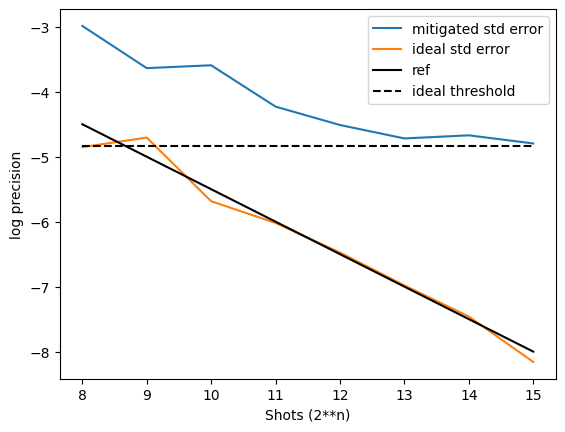

In [120]:
em_error = np.sqrt(np.square(em_std_err) + np.square(em_bias))
sv_error = np.sqrt(np.square(sv_std_err) + np.square(sv_bias)) #  + np.abs(sv_bias)
print(em_error)
print(sv_error)

# plt.plot(shots,np.log2(em_std_err), label="mitigated std error")
plt.plot(shots,np.log2(em_error), label="mitigated std error")
# plt.plot(shots,np.log2(np.abs(em_bias)), label="mitigated bias")
plt.plot(shots,np.log2(sv_error), label="ideal std error")
# plt.plot(shots, np.log2(np.abs(sv_bias)), label="ideal bias") 
plt.plot(shots, [np.log2(np.sqrt(1-ideal**2)/np.sqrt(2**s)) for s in shots], c = 'k', label = 'ref')
plt.hlines(np.log2(gamma/np.sqrt(4096)), 8, 15, linestyle = '--', color = 'k', label = 'ideal threshold')
plt.xlabel("Shots (2**n)")
plt.ylabel("log precision")
plt.legend()

In [125]:
from scipy.stats import bootstrap
from braket.devices import LocalSimulator
from braket.circuits.observables import Z

def apply_rem(circuit : Circuit, shots):
    ideal = LocalSimulator().run(circ + Circuit().expectation(Z(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5)), shots = 0).result().values[0]

    variants, masks  = apply_readout_twirl(circuit, 64)
    masks = [''.join('1' if s in ["X","Y"] else '0' for s in m) for m in masks]
    variants = [qd2._noise_model.apply(v.measure(range(6))) for v in variants]
    # print(variants[-1])
    pset = ProgramSet(variants, shots_per_executable= shots//64)
    print(f"shots_per_executable = {shots//64}")
    results = qd2.run(pset).result()
 
    dist = {}
    evs = []
    for item, mask in zip(results, masks):
        for k, v in item.entries[0].counts.items():
            kp = ''.join(str(int(a) ^ int(b)) for a, b in zip(k, mask))
            dist[kp] = dist.get(kp, 0) + v

    dist = mitigate_measurements(MeasurementResult.from_counts(dist), inverse_confusion_matrix=mat).get_counts()
    # dist = modified_mitigate_measurements(MeasurementResult.from_counts(dist), inverse_confusion_matrix=mat) # .get_counts()
    
    print(dist)
    tally_m1 = 0
    tally_p1 = 0
    for k,v in dist.items():
        if k.count("1") % 2 == 0:
            tally_p1 += v
        else:
            tally_m1 += v
    assert tally_m1 > 1 and tally_p1 > 1, f"negative results: {tally_m1},{tally_p1}"
    vals = [+1] * tally_p1 + [-1] * tally_m1

    # res = bootstrap((vals,), lambda x : np.mean(x))

    noiseless = LocalSimulator().run(circ, shots = shots).result().measurement_counts
    ideal_vals = [(-1)**(k.count("1")) for k,v in noiseless.items() for i in range(v)]
    # res_ideal = bootstrap((ideal_vals,), lambda x : np.mean(x))
    return np.mean(vals), np.mean(ideal_vals)


angle = np.pi/4
circ = Circuit().h(range(6)).ry(range(6),np.pi/4)
circ = Circuit().h(0).cnot(0,1).cnot(1,2).cnot(1,3).ry(3,angle).cnot(3,4).cnot(4,5)
print(circ)
ideal = LocalSimulator().run(circ + Circuit().expectation(Z(0) @ Z(1) @ Z(2) @ Z(3) @ Z(4) @ Z(5)), shots = 0).result().values[0]
print(f"ideal: {ideal}")
assert abs(ideal) > 0.1
em_std_err_2 = []
em_bias_2 = []
sv_std_err_2 = []
sv_bias_2 = []

n_trials = 32
shots = [8,10,12,14,16,18]
for n in shots:
    temp_ideal= []
    temp_em = []
    for i in range(n_trials):
        em, sv = apply_rem(circ, 2**n)
        temp_ideal.append(sv)
        temp_em.append(em)
    em_std_err_2.append(bootstrap((temp_em, ), lambda x : np.average(x)).standard_error * np.sqrt(n_trials))
    sv_std_err_2.append(bootstrap((temp_ideal,), lambda x: np.average(x)).standard_error * np.sqrt(n_trials))
    em_bias_2.append(np.mean(temp_em) - ideal)
    sv_bias_2.append(np.mean(temp_ideal) - ideal)
    


T  : │  0  │  1  │  2  │  3  │     4      │  5  │  6  │
      ┌───┐                                            
q0 : ─┤ H ├───●────────────────────────────────────────
      └───┘   │                                        
            ┌─┴─┐                                      
q1 : ───────┤ X ├───●─────●────────────────────────────
            └───┘   │     │                            
                  ┌─┴─┐   │                            
q2 : ─────────────┤ X ├───┼────────────────────────────
                  └───┘   │                            
                        ┌─┴─┐ ┌──────────┐             
q3 : ───────────────────┤ X ├─┤ Ry(0.79) ├───●─────────
                        └───┘ └──────────┘   │         
                                           ┌─┴─┐       
q4 : ──────────────────────────────────────┤ X ├───●───
                                           └───┘   │   
                                                 ┌─┴─┐ 
q5 : ───────────────────────────────────────────

/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 11, '000000': 101, '111111': 114, '011111': 5, '000111': 13, '110001': 1, '110111': 3, '000101': 1, '000100': 2, '001001': 4, '001111': 1}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 108, '111111': 112, '000111': 24, '000100': 2, '011000': 1, '000001': 2, '111000': 4, '111011': 2, '001001': 1}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 129, '000000': 101, '111000': 11, '000111': 15}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000111': 12, '111111': 127, '111000': 15, '000000': 89, '101110': 3, '111101': 4, '000010': 5, '011000': 1}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 103, '000000': 111, '111000': 31, '000111': 8, '100001': 3}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 113, '000000': 90, '000111': 23, '111000': 20, '100000': 8, '000010': 2}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 113, '111111': 101, '000111': 14, '110111': 4, '111000': 11, '100000': 5, '111110': 2, '111101': 3, '011111': 3}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 116, '000000': 120, '111000': 8, '000111': 12}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 11, '000000': 132, '111111': 109, '000111': 4}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 109, '000000': 92, '000111': 15, '111000': 32, '011000': 1, '010000': 1, '110110': 2, '110111': 1, '100000': 2, '000110': 1}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 121, '000000': 78, '000001': 4, '111000': 23, '000111': 16, '011000': 2, '111011': 6, '111110': 2, '010000': 4}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 121, '111111': 94, '111000': 13, '000111': 24, '010111': 1, '011111': 1, '100000': 1, '111101': 1}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 84, '111111': 132, '111000': 14, '000111': 20, '011000': 2, '000010': 3, '011101': 1}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 89, '000000': 116, '000111': 16, '111000': 10, '111101': 3, '111011': 4, '100000': 5, '011111': 6, '101111': 2, '001000': 3, '111100': 2}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111110': 6, '111111': 114, '000000': 102, '000111': 7, '111000': 16, '111100': 1, '000110': 1, '001100': 1, '101000': 3, '011000': 1, '010111': 1, '000001': 1, '101111': 2}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111101': 5, '111111': 97, '000000': 121, '111001': 5, '000111': 12, '000010': 2, '110111': 5, '001111': 1, '111000': 2, '101001': 2, '010000': 1, '001110': 1, '101000': 1, '111110': 1}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 87, '111111': 126, '111000': 19, '011111': 9, '000111': 15}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 102, '000000': 112, '111000': 16, '100100': 2, '000111': 12, '100011': 1, '110111': 4, '101111': 4, '110000': 2, '000010': 1}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 104, '111111': 104, '111000': 18, '100000': 6, '000111': 24}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 118, '111111': 102, '111000': 14, '000111': 18, '101000': 4}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 114, '000000': 100, '110111': 13, '000111': 9, '111000': 11, '111011': 6, '011111': 2, '000101': 1}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 107, '000000': 101, '000111': 17, '111000': 25, '001000': 4, '111110': 2}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 132, '000111': 12, '111111': 93, '111000': 19}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000100': 2, '000000': 81, '111111': 120, '111000': 31, '000111': 19, '000001': 3}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'110111': 2, '111000': 17, '111111': 102, '000111': 24, '000000': 97, '011111': 5, '100000': 4, '110000': 2, '000100': 2, '111110': 1}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 109, '000000': 110, '000111': 17, '111000': 10, '011111': 9, '010000': 1}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 93, '111111': 118, '111011': 1, '111000': 13, '000111': 19, '001000': 5, '000001': 4, '000100': 3}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 95, '000000': 103, '000111': 12, '000010': 6, '000100': 3, '111110': 5, '111000': 22, '001000': 6, '111011': 1, '100000': 3}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 93, '000000': 104, '111000': 15, '111101': 7, '000111': 24, '001111': 1, '110111': 2, '000010': 6, '001000': 2, '101110': 1, '000001': 1}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 121, '111111': 108, '000111': 5, '111000': 20, '001000': 2}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 100, '000111': 21, '100000': 2, '111000': 20, '111111': 91, '000010': 3, '110000': 2, '010000': 4, '111101': 5, '111011': 1, '000100': 3, '101000': 4}
shots_per_executable = 4


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 102, '000111': 10, '000000': 122, '011111': 4, '101111': 5, '111000': 11, '001111': 2}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 397, '111111': 452, '111000': 66, '000111': 89, '001000': 10, '100000': 7, '001111': 3}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 427, '111111': 406, '011000': 6, '111000': 79, '000111': 80, '101011': 1, '011111': 8, '111101': 14, '110111': 2, '000010': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000111': 67, '111111': 445, '000000': 412, '011111': 27, '001000': 11, '000010': 12, '111000': 49, '000100': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 436, '100000': 3, '111111': 446, '000111': 56, '111000': 63, '000011': 1, '110110': 3, '111110': 4, '000110': 3, '100100': 1, '011110': 3, '011000': 4, '111101': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 439, '111111': 418, '111000': 94, '000111': 73}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 430, '000000': 413, '000111': 51, '100000': 19, '111000': 84, '011111': 17, '000110': 2, '111101': 4, '110110': 4}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 423, '111111': 453, '111000': 58, '000111': 62, '100000': 14, '000100': 6, '111110': 2, '010111': 2, '100111': 3, '001110': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 444, '000000': 431, '111000': 79, '000111': 52, '000010': 2, '001000': 6, '011111': 2, '100000': 3, '001111': 1, '100111': 2, '010111': 1, '111101': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 400, '000000': 443, '000111': 53, '111000': 73, '101011': 4, '100111': 3, '100000': 24, '011111': 20, '010000': 1, '000101': 2, '001001': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 413, '000000': 422, '111000': 66, '000111': 93, '010000': 10, '001000': 10, '011110': 3, '011111': 5, '011101': 2}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 392, '111111': 438, '000111': 97, '111000': 79, '101111': 9, '100000': 4, '111100': 1, '000100': 4}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111101': 4, '111000': 124, '111111': 395, '000000': 391, '000111': 57, '100000': 13, '000010': 5, '110000': 7, '101111': 3, '001000': 11, '101000': 5, '000001': 8, '100111': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 437, '111000': 89, '000000': 407, '001000': 12, '000111': 57, '011111': 7, '111101': 5, '000010': 3, '100000': 5, '110111': 1, '100001': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 432, '000111': 61, '000000': 415, '111000': 54, '100000': 15, '011111': 21, '111100': 8, '110111': 11, '010000': 2, '000100': 2, '001010': 3}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 400, '000000': 406, '000001': 20, '111000': 75, '111110': 2, '001000': 9, '000111': 108, '000010': 2, '100010': 1, '011101': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000111': 98, '111000': 75, '111111': 406, '000000': 369, '010000': 2, '111110': 19, '001000': 12, '101111': 3, '110111': 5, '100000': 12, '000010': 6, '111101': 5, '000100': 3, '111010': 6, '000001': 1, '101000': 2}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 377, '000111': 83, '111101': 8, '111000': 88, '111011': 11, '000000': 426, '110111': 4, '101011': 1, '011111': 8, '000001': 8, '011000': 4, '001010': 6}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 404, '000111': 86, '000000': 389, '111000': 81, '011111': 24, '111100': 3, '001000': 2, '110111': 18, '000100': 7, '101111': 8, '000011': 2}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 461, '000000': 418, '000111': 63, '111000': 62, '111110': 10, '100000': 9, '011000': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 382, '000000': 423, '000111': 80, '000100': 10, '111000': 80, '101111': 15, '100000': 10, '000110': 1, '011111': 9, '010111': 3, '111011': 10, '011110': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 470, '111111': 419, '111000': 71, '000111': 51, '111110': 2, '101000': 3, '001000': 2, '001111': 3, '100000': 2, '010001': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000111': 73, '000000': 394, '111111': 463, '111000': 71, '100000': 13, '101111': 5, '000011': 5}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 445, '001000': 14, '000000': 424, '111000': 38, '000111': 65, '000001': 8, '010111': 11, '101110': 1, '111010': 10, '111011': 2, '011111': 1, '100010': 3, '111100': 1, '010000': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 429, '111000': 69, '111111': 449, '000111': 48, '111011': 3, '000010': 8, '111110': 6, '101111': 3, '011000': 4, '000100': 1, '100111': 4}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 436, '111111': 402, '111100': 6, '000111': 74, '111000': 69, '110000': 2, '101111': 13, '110110': 2, '111011': 11, '101000': 4, '011000': 2, '111001': 2, '100001': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 413, '111111': 413, '000001': 2, '000111': 59, '100000': 34, '111000': 84, '101111': 12, '110111': 3, '000010': 4}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 414, '000111': 69, '000000': 414, '111000': 87, '001111': 9, '011111': 12, '000010': 4, '001000': 4, '000101': 3, '000001': 7, '100000': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'110111': 5, '000000': 426, '111111': 419, '111000': 71, '000111': 91, '100000': 8, '111101': 2, '111110': 1, '010000': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 99, '000000': 398, '111111': 431, '000111': 66, '111011': 1, '010000': 6, '001000': 5, '110111': 3, '111101': 1, '000010': 6, '000001': 1, '000110': 4, '111110': 1, '010111': 1, '100000': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 484, '111111': 360, '011111': 10, '111000': 73, '000111': 64, '011000': 9, '000100': 5, '001000': 12, '111001': 1, '101111': 5, '110110': 1}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 393, '000000': 447, '000111': 64, '111000': 89, '111010': 1, '111110': 2, '011111': 19, '100000': 3, '000010': 3, '100001': 3}
shots_per_executable = 16


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 467, '111000': 59, '000000': 388, '000111': 48, '000100': 6, '110111': 6, '110000': 6, '100000': 10, '111101': 8, '000010': 3, '101111': 4, '001000': 5, '100001': 3, '101000': 4, '111100': 5, '001111': 2}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1775, '000000': 1646, '111000': 323, '000111': 296, '111011': 5, '100000': 1, '001000': 32, '010110': 2, '111101': 7, '101011': 3, '001111': 6}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1649, '000000': 1758, '000111': 294, '111000': 271, '000010': 8, '101111': 13, '100111': 13, '010000': 4, '101000': 19, '000101': 13, '111101': 18, '000001': 2, '100000': 7, '000011': 4, '011111': 16, '110010': 2, '001111': 2, '011110': 3}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 1662, '111111': 1755, '111000': 257, '000111': 267, '100000': 31, '110000': 11, '111110': 13, '110111': 13, '010111': 4, '001000': 32, '001110': 1, '111001': 4, '000010': 19, '111010': 3, '110101': 5, '100100': 3, '011000': 2, '100011': 1, '000100': 1, '001100': 1, '011111': 7, '100110': 3, '010100': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 1723, '000111': 249, '111101': 11, '111111': 1724, '111000': 293, '000100': 16, '011111': 16, '011010': 5, '010111': 13, '000010': 13, '110111': 1, '111001': 3, '100111': 11, '011000': 10, '111110': 4, '100001': 2, '011110': 2}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 1686, '111111': 1654, '111000': 273, '101111': 29, '110111': 10, '000111': 294, '111011': 26, '100000': 29, '011111': 29, '101000': 16, '001000': 11, '100111': 2, '001111': 4, '111001': 6, '000010': 14, '100010': 3, '000100': 6, '010100': 4}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'011111': 60, '111000': 286, '000000': 1716, '111111': 1704, '100000': 27, '000111': 261, '101111': 10, '001000': 17, '110111': 6, '100111': 8, '110000': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1706, '000000': 1619, '000111': 259, '111000': 296, '000100': 20, '001000': 31, '011111': 38, '111101': 22, '000010': 16, '000001': 33, '100000': 20, '110111': 30, '000110': 3, '010000': 1, '100111': 2}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 259, '111111': 1682, '000000': 1696, '000111': 294, '100000': 12, '011001': 1, '011111': 34, '001000': 5, '111110': 25, '110111': 18, '101111': 11, '111101': 21, '011110': 5, '010000': 8, '000110': 13, '000101': 4, '010001': 6, '110000': 1, '111001': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'100111': 22, '111111': 1667, '000111': 275, '000000': 1685, '111000': 322, '110111': 18, '000100': 9, '100000': 23, '111011': 18, '001111': 11, '011111': 11, '110000': 3, '001100': 2, '000010': 3, '000001': 7, '111110': 4, '010101': 2, '001000': 4, '010010': 3, '011101': 1, '011110': 1, '111010': 4, '110001': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1670, '000000': 1721, '111000': 307, '010111': 3, '000111': 303, '011111': 40, '000100': 4, '100011': 1, '000010': 13, '100000': 21, '011101': 4, '111010': 4, '110000': 2, '001110': 3}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000111': 329, '000000': 1723, '111111': 1724, '111000': 271, '100000': 32, '011111': 2, '100111': 8, '001001': 6, '101111': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 273, '111111': 1659, '000000': 1691, '000111': 327, '110111': 39, '111110': 6, '100000': 25, '101111': 6, '011000': 7, '000010': 12, '010000': 7, '110000': 5, '011111': 20, '111101': 11, '011011': 3, '010110': 3, '000100': 2}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 1632, '111111': 1702, '000111': 297, '111000': 288, '001000': 45, '011111': 63, '110111': 18, '000001': 22, '111101': 12, '000011': 7, '111110': 2, '010000': 7, '000110': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1737, '000000': 1624, '001000': 35, '000111': 281, '111000': 297, '110111': 9, '100000': 46, '000100': 13, '111011': 15, '000011': 4, '011111': 15, '001100': 2, '000110': 9, '010000': 1, '110000': 1, '111001': 2, '111101': 3, '101100': 1, '101101': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 1715, '111000': 275, '100000': 29, '111111': 1756, '000111': 253, '011111': 52, '111101': 16}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 1590, '111111': 1822, '000111': 308, '100000': 25, '111000': 289, '111011': 17, '111101': 3, '000001': 4, '000010': 5, '000100': 5, '100111': 12, '101111': 8, '001000': 3, '101000': 4, '100001': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 1698, '000111': 290, '111111': 1663, '000100': 29, '111000': 252, '101111': 5, '000010': 14, '100000': 32, '001000': 11, '100111': 8, '010100': 4, '011111': 29, '001001': 5, '101110': 1, '111110': 5, '110100': 6, '110001': 6, '110010': 2, '110111': 11, '010101': 1, '011000': 9, '101011': 2, '000011': 3, '001111': 1, '101000': 1, '001100': 2, '011011': 2, '100001': 3, '010110': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1786, '000000': 1698, '000111': 262, '100000': 37, '111000': 258, '111011': 12, '000100': 4, '000010': 12, '010001': 3, '010111': 6, '111101': 9, '011111': 5, '000110': 3, '011101': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111001': 10, '001111': 3, '110111': 21, '111111': 1690, '000000': 1724, '000111': 275, '111000': 280, '111011': 23, '011000': 5, '100000': 26, '010000': 5, '011111': 18, '000010': 4, '101000': 4, '111101': 7, '101111': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 1700, '111000': 297, '111111': 1770, '000111': 240, '001000': 34, '011111': 13, '100000': 12, '100111': 17, '111101': 8, '011100': 1, '011000': 3, '101110': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1751, '000000': 1745, '111000': 283, '000111': 287, '110111': 10, '000010': 10, '000101': 3, '100000': 5, '001000': 2}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 288, '111111': 1675, '000111': 261, '000000': 1689, '101000': 34, '001000': 5, '110011': 1, '100000': 45, '000001': 4, '111101': 32, '111011': 13, '011000': 3, '001101': 1, '111001': 4, '100100': 4, '100111': 13, '111110': 15, '000010': 5, '101010': 3, '010111': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1789, '000000': 1667, '000111': 226, '111000': 274, '111011': 23, '100000': 43, '011111': 34, '010000': 11, '000101': 4, '001000': 11, '000100': 4, '010001': 6, '101101': 2, '100111': 1, '000001': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1650, '000000': 1685, '111000': 346, '000111': 277, '011111': 19, '110111': 24, '100000': 35, '100111': 17, '000101': 1, '000001': 20, '111101': 2, '101111': 7, '000100': 3, '011110': 1, '011001': 1, '100010': 2, '010111': 6}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000111': 259, '111111': 1720, '111000': 347, '000000': 1685, '011111': 4, '100000': 35, '110111': 13, '101000': 5, '111011': 11, '011011': 5, '101111': 3, '001010': 8, '010000': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 1763, '000111': 300, '111111': 1608, '111000': 266, '100010': 10, '111110': 17, '101111': 34, '010000': 20, '010111': 20, '000110': 7, '011111': 16, '110111': 15, '110000': 1, '100001': 4, '111001': 4, '111011': 8, '011110': 3}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1780, '000000': 1738, '000111': 271, '111000': 266, '111101': 22, '111011': 4, '100111': 11, '010000': 3, '000110': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1725, '000000': 1691, '000010': 27, '111000': 302, '000111': 317, '011111': 22, '010111': 8, '000101': 3, '011000': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1773, '000000': 1672, '000111': 266, '111000': 333, '100111': 7, '110111': 4, '100000': 18, '111011': 10, '010001': 4, '001111': 3, '000110': 2, '011111': 4}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1708, '000111': 313, '111101': 8, '000000': 1647, '011111': 20, '111000': 292, '100100': 4, '100000': 15, '110111': 21, '000010': 10, '111011': 11, '101000': 9, '111110': 4, '000110': 4, '010000': 5, '001111': 13, '000100': 5, '100001': 1, '110010': 1, '000001': 1, '000101': 3, '110011': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1664, '000000': 1664, '111000': 314, '000111': 282, '100000': 65, '011111': 26, '111101': 13, '001000': 10, '100110': 1, '001111': 21, '010001': 1, '000100': 15, '111110': 4, '001010': 4, '101111': 1, '011011': 5, '010111': 5, '000010': 1}
shots_per_executable = 64


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 1763, '000000': 1654, '000111': 283, '001000': 29, '100111': 13, '111000': 254, '000100': 12, '111001': 2, '111100': 2, '010000': 7, '100000': 37, '111101': 7, '011111': 15, '010111': 3, '000010': 15}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 6988, '111111': 6807, '111000': 1137, '000111': 1052, '110111': 36, '111101': 25, '011000': 28, '110000': 11, '100000': 117, '010010': 8, '011111': 123, '001000': 27, '011100': 4, '000010': 19, '000011': 2}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 6559, '111111': 7003, '111000': 1171, '000111': 1195, '000001': 33, '100000': 147, '110111': 24, '101111': 19, '011111': 73, '111101': 18, '001000': 42, '100111': 20, '111010': 29, '011000': 7, '010000': 21, '100010': 2, '000101': 2, '010111': 6, '000010': 13}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6719, '000000': 6911, '000111': 1150, '111000': 1194, '100000': 167, '001000': 57, '100111': 32, '100010': 1, '110111': 42, '101000': 6, '111010': 14, '001111': 35, '011011': 7, '101111': 14, '000100': 10, '111110': 10, '111100': 4, '011111': 6, '101011': 1, '010010': 1, '010001': 1, '111101': 1, '101101': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6869, '000000': 6692, '111000': 1157, '000111': 1115, '011111': 95, '000001': 18, '100000': 112, '101111': 61, '010111': 24, '011000': 43, '010000': 28, '001111': 4, '100111': 26, '000110': 22, '000101': 20, '011110': 4, '110011': 6, '000100': 42, '000011': 3, '110110': 3, '101101': 1, '111011': 8, '001000': 6, '111100': 4, '000010': 8, '001011': 4, '101110': 2, '011011': 1, '001001': 1, '110101': 2, '110100': 1, '111101': 1, '101000': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 6753, '111111': 7156, '000111': 1082, '100011': 6, '111000': 1161, '100000': 35, '011000': 49, '000110': 21, '110000': 12, '000010': 38, '000100': 6, '011111': 29, '000101': 13, '100111': 3, '110101': 4, '011001': 3, '101101': 1, '111100': 3, '010000': 2, '111010': 1, '010110': 2, '011101': 2, '001011': 1, '111101': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 7134, '111111': 6672, '111011': 21, '111000': 1050, '111110': 90, '000111': 1119, '011111': 175, '111101': 15, '010000': 16, '100111': 23, '110111': 35, '000010': 14, '011011': 2, '101000': 7, '111010': 4, '010100': 2, '001010': 2, '100010': 1, '001110': 1, '101100': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 6991, '011111': 189, '111111': 6624, '111000': 1162, '000111': 1220, '000011': 12, '101111': 16, '001000': 51, '111101': 31, '110101': 1, '000100': 15, '111011': 30, '011000': 2, '111100': 7, '110000': 2, '100010': 3, '100100': 10, '011011': 8, '010111': 7, '011100': 1, '110010': 1, '101001': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 1177, '111111': 6733, '110000': 17, '000000': 6873, '000111': 1162, '011111': 98, '100111': 58, '001111': 29, '100000': 104, '001000': 5, '010000': 7, '110111': 52, '111010': 3, '000010': 20, '000100': 18, '111110': 12, '111011': 16}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6724, '111011': 51, '000000': 6993, '111000': 1075, '000111': 1208, '101111': 27, '011111': 124, '110111': 36, '100000': 57, '101000': 13, '100001': 2, '010010': 9, '000100': 13, '011000': 24, '100111': 2, '101100': 3, '001101': 2, '010000': 4, '110011': 7, '111010': 1, '111100': 5, '111110': 1, '010101': 1, '011101': 1, '001010': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 6996, '111111': 6580, '101111': 43, '111000': 1149, '101000': 18, '000111': 1227, '100000': 44, '011111': 131, '110111': 116, '011000': 14, '111011': 8, '000100': 29, '110000': 12, '111101': 15, '001000': 2}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 6811, '000111': 1162, '111111': 6748, '000010': 20, '111000': 1121, '111011': 57, '011111': 135, '101111': 57, '100000': 86, '001000': 67, '010000': 28, '000100': 37, '000011': 9, '011101': 1, '101100': 5, '011011': 1, '101110': 3, '100111': 20, '110111': 5, '001111': 6, '001001': 1, '011000': 1, '100001': 1, '111010': 1, '010011': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 6960, '111111': 6523, '000111': 1202, '111000': 1174, '011111': 257, '001000': 51, '110111': 106, '000001': 10, '101111': 16, '010000': 8, '010111': 11, '111101': 34, '111110': 19, '001110': 2, '101100': 1, '100110': 2, '000100': 1, '011010': 1, '110100': 1, '001101': 1, '000011': 1, '111011': 3}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6849, '000000': 6900, '111000': 1176, '000111': 1143, '100000': 82, '101111': 21, '011111': 106, '001000': 23, '110111': 52, '111011': 31, '001111': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'100000': 81, '000000': 6726, '111111': 7035, '111000': 1150, '000111': 1197, '111100': 27, '110111': 26, '001000': 35, '100111': 9, '100001': 14, '011110': 14, '100010': 8, '010001': 1, '000100': 3, '111001': 10, '001111': 7, '000010': 7, '101101': 2, '100110': 1, '110101': 3, '110110': 7, '000101': 2, '101000': 6, '100100': 2, '011111': 2, '011000': 8, '101110': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6940, '000000': 6786, '111000': 1209, '000111': 1123, '100000': 91, '011000': 13, '011111': 77, '001000': 48, '110111': 45, '000011': 11, '101100': 1, '000101': 15, '010010': 2, '101111': 16, '110011': 1, '111010': 4, '010100': 1, '001110': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6946, '000000': 6703, '111000': 1228, '000111': 1128, '011000': 25, '100111': 29, '001000': 49, '100000': 60, '011111': 159, '000100': 27, '110111': 14, '011011': 1, '111010': 4, '000010': 11}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6727, '000000': 7003, '111000': 1194, '000111': 1115, '010000': 55, '101111': 17, '111101': 34, '100000': 88, '000010': 30, '011111': 70, '100111': 21, '111011': 19, '100110': 1, '110111': 3, '011000': 1, '001010': 1, '101011': 1, '010100': 1, '101001': 1, '010110': 1, '010101': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 6885, '000111': 1261, '111111': 6602, '111000': 1175, '110111': 84, '101000': 12, '111101': 39, '011111': 79, '100000': 106, '001000': 14, '100111': 93, '110010': 1, '101011': 2, '000011': 1, '111011': 6, '000101': 1, '110101': 1, '110000': 6, '100001': 1, '110100': 6, '001101': 1, '111010': 3, '001010': 2, '111100': 1, '010110': 1, '010001': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 6624, '111111': 6979, '111000': 1166, '001000': 58, '000111': 1192, '100000': 171, '110111': 62, '011111': 59, '000100': 14, '010000': 44, '111101': 15}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 6861, '100000': 69, '111111': 6705, '111110': 83, '110111': 32, '111000': 1156, '100101': 4, '111101': 11, '010000': 39, '000111': 1135, '001111': 22, '011111': 88, '010110': 15, '001101': 1, '001000': 59, '011000': 25, '000010': 24, '001011': 2, '000100': 10, '100111': 9, '111001': 8, '100100': 4, '011011': 3, '100001': 3, '101000': 8, '001001': 3, '100110': 1, '011001': 2, '010001': 1, '101011': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6835, '111000': 1224, '000000': 6757, '000111': 1156, '111100': 8, '001000': 35, '100000': 168, '111101': 50, '110000': 14, '010000': 26, '111011': 6, '110111': 37, '100111': 14, '011111': 21, '011110': 13, '011001': 2, '001101': 1, '011101': 4, '001110': 2, '001111': 6, '110010': 2, '100011': 2, '010111': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6876, '111000': 1220, '000000': 6650, '101111': 76, '000111': 1191, '110111': 73, '100000': 132, '001000': 19, '011111': 110, '100111': 15, '111011': 8, '011000': 3, '110101': 9, '111100': 1, '100010': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 6735, '111111': 6677, '111000': 1200, '100000': 61, '000111': 1257, '011111': 121, '101000': 23, '010000': 9, '100011': 2, '001000': 36, '110000': 32, '110111': 50, '111101': 5, '011000': 44, '111110': 11, '101111': 32, '111001': 4, '100111': 37, '101100': 3, '111011': 14, '000101': 4, '010001': 8, '000010': 4, '011110': 5, '011011': 2, '010101': 1, '011010': 1, '010111': 3, '000011': 1, '110010': 1, '111010': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 7130, '000111': 1185, '111000': 1101, '000000': 6573, '100111': 17, '100000': 140, '110000': 17, '011111': 101, '001000': 62, '111010': 10, '101111': 26, '010001': 4, '000010': 9, '101000': 5, '111100': 3, '110011': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000111': 1154, '111111': 6924, '111000': 1227, '000000': 6661, '100000': 95, '111011': 28, '011111': 100, '110111': 88, '010000': 9, '001000': 30, '000010': 27, '111010': 5, '110011': 2, '101000': 2, '101001': 1, '000110': 3, '111101': 2, '110000': 7, '010100': 5, '100110': 2, '010010': 1, '011101': 2, '110001': 2, '011110': 1, '100101': 1, '100111': 1, '101100': 1, '011011': 1, '100011': 1, '110100': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6789, '000000': 6903, '111000': 1121, '000111': 1064, '111010': 8, '011111': 197, '111110': 19, '001000': 53, '111101': 43, '110111': 21, '011011': 1, '110110': 3, '101101': 3, '000010': 18, '011000': 35, '010000': 60, '100111': 9, '000101': 5, '100001': 2, '011110': 4, '110000': 13, '010101': 1, '101010': 1, '110101': 1, '000110': 4, '110011': 3, '011101': 1, '100010': 2}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 6952, '111111': 6731, '111000': 1195, '000111': 1238, '011111': 127, '011000': 29, '110111': 50, '001000': 28, '100000': 24, '111011': 10}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6891, '000000': 6917, '111000': 1164, '000111': 1118, '100000': 113, '011111': 84, '111011': 27, '000010': 14, '100111': 31, '110111': 19, '111101': 6}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6681, '000000': 6830, '000111': 1071, '111000': 1268, '101111': 41, '001000': 100, '100111': 22, '111011': 17, '000010': 55, '100000': 57, '110111': 11, '010000': 51, '101000': 5, '101010': 4, '111100': 9, '011000': 11, '011111': 87, '010111': 36, '101100': 1, '110100': 1, '100010': 1, '111110': 11, '001111': 1, '000011': 11, '101001': 1, '100101': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 7017, '111111': 6513, '000111': 1176, '111000': 1206, '100000': 86, '001000': 80, '011000': 8, '101111': 64, '111101': 9, '011111': 107, '010111': 1, '010000': 34, '111011': 28, '000010': 11, '000011': 5, '111110': 23, '000100': 1, '011110': 3, '001101': 1, '000101': 2, '101010': 3, '111100': 1, '100111': 2, '001011': 1, '000110': 1, '010011': 1}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000111': 1184, '000000': 6844, '111111': 6838, '111110': 46, '111000': 1236, '100000': 143, '000010': 14, '010111': 13, '100111': 15, '110111': 15, '001000': 34, '110000': 2}
shots_per_executable = 256


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 6999, '111000': 1213, '000000': 6586, '001000': 27, '000111': 1146, '100000': 154, '111101': 28, '010000': 48, '111010': 21, '000010': 64, '001111': 8, '110000': 9, '100111': 35, '110111': 23, '000100': 16, '011110': 2, '011011': 5}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 27237, '111111': 27328, '000111': 4535, '111000': 4779, '110111': 229, '100000': 486, '101111': 131, '000100': 47, '100111': 61, '001000': 27, '011111': 302, '000011': 67, '110110': 26, '110000': 34, '111100': 15, '111001': 4, '001111': 28, '101000': 7, '111011': 27, '111010': 2, '011000': 9, '010000': 83, '101011': 8, '001011': 3, '011101': 1, '000001': 3, '010011': 3, '110001': 4, '000010': 4, '000101': 13, '111101': 13, '101101': 5, '010100': 3, '110010': 2, '110011': 4, '101010': 1, '000110': 4, '001101': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 27580, '011111': 495, '111111': 27038, '000111': 4636, '011000': 184, '111000': 4724, '111011': 176, '001000': 56, '111101': 37, '100000': 218, '111010': 23, '111100': 4, '110111': 235, '000010': 24, '101111': 36, '110000': 13, '000001': 10, '100010': 39, '110001': 1, '010010': 1, '010000': 1, '001111': 1, '100011': 1, '101001': 1, '000101': 1, '010101': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27222, '000000': 27284, '000111': 4680, '111000': 4567, '111101': 116, '100000': 721, '001000': 233, '011111': 255, '100111': 108, '101111': 122, '111100': 24, '010000': 22, '100101': 2, '011000': 5, '000100': 56, '110111': 26, '111011': 46, '001110': 6, '011011': 1, '101000': 13, '001111': 2, '110110': 2, '001101': 2, '110011': 3, '101110': 2, '000010': 1, '100100': 2, '010100': 2, '010001': 2, '000011': 3, '110101': 3, '010010': 2, '010011': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27669, '000000': 26699, '000111': 4702, '111000': 4760, '001000': 105, '111101': 110, '110111': 150, '100000': 464, '000001': 209, '100111': 70, '100010': 13, '010000': 162, '011111': 227, '000010': 46, '011101': 2, '101111': 48, '000100': 56, '011001': 6, '001110': 2, '110001': 2, '001010': 2, '101011': 1, '011000': 7, '111011': 7, '111100': 2, '011010': 2, '010101': 1, '000101': 1, '011110': 2, '111010': 1, '100100': 5, '011011': 1, '001001': 1, '110110': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 4630, '111111': 27188, '010000': 134, '000000': 27504, '000111': 4564, '111101': 62, '011111': 376, '010111': 40, '110111': 195, '100000': 358, '100111': 59, '001000': 91, '110000': 47, '101111': 82, '011000': 43, '111011': 56, '000110': 32, '100001': 8, '000010': 21, '101000': 4, '001100': 2, '011110': 24, '110010': 1, '010101': 5, '001011': 2, '111010': 3, '110011': 3, '011001': 1, '101010': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 27278, '111000': 4784, '000111': 4537, '111111': 27100, '110000': 63, '011111': 267, '110111': 154, '100111': 147, '001000': 228, '111101': 108, '100000': 513, '000100': 19, '111011': 109, '010000': 131, '011000': 22, '011010': 5, '001110': 4, '100001': 15, '010101': 2, '101101': 5, '110010': 5, '010010': 7, '100100': 8, '001100': 5, '101000': 5, '000010': 5, '010100': 3, '000101': 2, '100110': 1, '101011': 1, '011100': 1, '011110': 1, '001101': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27419, '000000': 27210, '111000': 4633, '000111': 4565, '011111': 433, '001000': 422, '101111': 171, '100000': 170, '000010': 86, '011000': 35, '111101': 228, '001111': 74, '010111': 6, '110000': 9, '111011': 24, '100111': 22, '000100': 24, '011110': 5}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27153, '000000': 27016, '000111': 4913, '011111': 524, '111000': 4686, '010111': 111, '010000': 95, '011000': 169, '111101': 100, '100000': 182, '101111': 232, '001000': 113, '110001': 5, '100100': 6, '001111': 18, '011011': 6, '101000': 33, '101001': 3, '111011': 25, '110111': 12, '000100': 61, '000010': 11, '001100': 3, '010010': 4, '110000': 10, '000101': 6, '110011': 6, '100010': 4, '001010': 6, '100101': 5, '010101': 1, '100011': 3, '001101': 1, '100001': 9, '001011': 2, '000110': 2}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 4693, '111111': 27026, '000000': 27350, '011000': 78, '011111': 518, '111101': 81, '000111': 4811, '101111': 104, '000101': 24, '001001': 17, '000100': 40, '000010': 53, '110111': 258, '100000': 189, '010000': 59, '000001': 126, '010110': 1, '110000': 20, '111011': 13, '000011': 4, '010101': 2, '101011': 1, '111001': 11, '101000': 18, '011101': 2, '100100': 2, '100111': 13, '011100': 3, '011011': 3, '100011': 1, '010111': 2, '110001': 4, '001100': 1, '010001': 2, '001000': 1, '010100': 2, '100110': 2, '100010': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 26559, '100000': 369, '000000': 27603, '000111': 4800, '111000': 4853, '101111': 109, '011111': 362, '110111': 235, '001111': 11, '011000': 64, '100111': 36, '111101': 97, '101000': 56, '010000': 99, '111011': 35, '000010': 100, '111100': 35, '100010': 2, '111110': 40, '110000': 2, '001011': 2, '110101': 4, '101011': 5, '011011': 5, '011001': 15, '001001': 4, '011100': 1, '001000': 9, '101101': 1, '010111': 7, '010011': 4, '110010': 2, '101001': 1, '100110': 1, '001110': 2, '101110': 1, '000101': 3, '101010': 1, '111010': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 26972, '000111': 4951, '000000': 27441, '111000': 4685, '000010': 26, '011111': 833, '011000': 86, '101111': 55, '111101': 64, '001000': 191, '010000': 65, '111001': 42, '010001': 4, '100111': 34, '101000': 3, '000001': 6, '001101': 7, '111011': 13, '010111': 2, '110101': 1, '110010': 2, '010110': 5, '101001': 5, '100100': 9, '010101': 2, '110000': 4, '010010': 4, '100000': 3, '001100': 3, '011001': 4, '001010': 2, '010100': 4, '110011': 2, '000011': 2, '110001': 1, '011011': 1, '100001': 2}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27335, '000000': 27391, '000111': 4513, '111000': 4698, '110111': 120, '100111': 31, '100000': 478, '000100': 16, '001000': 120, '000010': 75, '111100': 29, '011111': 413, '010000': 67, '001100': 32, '101110': 27, '111011': 39, '111101': 20, '101111': 88, '101000': 23, '011000': 19, '110000': 2}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 27334, '000111': 4578, '111111': 27279, '111000': 4920, '100000': 504, '011000': 21, '011111': 266, '111011': 79, '001000': 151, '010000': 79, '111110': 24, '101000': 51, '100111': 46, '101111': 36, '001111': 80, '001010': 2, '111010': 12, '000100': 14, '010110': 6, '101011': 8, '111100': 4, '110111': 6, '010101': 5, '011001': 2, '000010': 2, '100101': 4, '100110': 4, '110011': 2, '011110': 8, '110100': 1, '100011': 3, '001001': 1, '011011': 2, '101110': 2}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 27249, '000111': 4546, '111111': 27581, '111000': 4641, '111011': 73, '100111': 103, '011111': 493, '011000': 48, '010000': 39, '101111': 19, '101000': 29, '000011': 14, '001000': 188, '100000': 260, '001111': 77, '000010': 43, '101101': 31, '111101': 27, '001010': 25, '100001': 7, '001100': 3, '101011': 4, '110000': 8, '010111': 7, '101110': 3, '010110': 4, '101010': 4, '010011': 4, '010010': 2, '110010': 1, '111001': 1, '100100': 1, '101001': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 4551, '111111': 27456, '000111': 4576, '000000': 27184, '011111': 194, '100000': 657, '110111': 265, '111100': 6, '011000': 10, '110000': 68, '010000': 56, '001111': 29, '000100': 113, '010111': 60, '100111': 138, '110010': 3, '111011': 28, '001100': 4, '101110': 1, '101000': 37, '000001': 47, '101111': 27, '110100': 1, '111010': 14, '110101': 3, '101101': 1, '111101': 3, '101010': 2, '100101': 1, '100010': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27308, '000000': 26812, '110111': 211, '111000': 4889, '000111': 4780, '100000': 352, '011000': 80, '001000': 160, '011111': 381, '000101': 14, '000100': 92, '010000': 130, '111101': 49, '101000': 74, '100110': 7, '000010': 56, '100011': 7, '100101': 16, '111011': 62, '101111': 4, '110100': 2, '010111': 4, '111010': 5, '110000': 4, '000001': 3, '101101': 4, '100111': 6, '011010': 4, '111001': 2, '010101': 4, '101010': 1, '001101': 1, '011100': 1, '110101': 2, '110010': 3, '101110': 3, '010011': 1, '001001': 1, '001011': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 4889, '000000': 27019, '111111': 27494, '100000': 647, '000111': 4604, '111010': 11, '000100': 90, '101111': 79, '110111': 8, '011111': 91, '101000': 13, '001000': 170, '010111': 68, '000010': 83, '011000': 6, '100111': 108, '111011': 41, '011101': 7, '111101': 30, '110000': 30, '111100': 2, '000110': 4, '001100': 4, '010100': 1, '100100': 4, '000011': 10, '001111': 5, '000101': 2, '101011': 3, '010101': 4, '110110': 4, '100011': 2, '110001': 2, '010001': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000111': 4670, '111000': 4587, '000000': 27161, '111111': 27450, '100000': 497, '000001': 10, '011111': 280, '000010': 50, '110111': 298, '100111': 112, '011000': 54, '010000': 160, '000100': 16, '111011': 85, '101111': 24, '110000': 62, '111101': 20}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 27370, '111000': 4505, '111111': 27129, '101110': 7, '000111': 4746, '101111': 127, '001000': 260, '110111': 39, '010000': 48, '000010': 50, '011111': 790, '111101': 163, '011000': 106, '001111': 20, '000100': 109, '000001': 27, '111011': 17, '101000': 10, '110000': 13}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27712, '000000': 27248, '111000': 4793, '000111': 4463, '011111': 495, '000010': 105, '100111': 49, '001000': 282, '100000': 116, '011000': 53, '001111': 29, '101000': 20, '111011': 5, '000101': 13, '110100': 2, '000110': 4, '111101': 25, '111001': 21, '000100': 37, '001011': 8, '010101': 3, '101110': 9, '100101': 2, '010001': 10, '011010': 5, '010010': 2, '101101': 5, '111010': 2, '001001': 1, '010111': 4, '100001': 1, '100010': 4, '011011': 3, '010100': 1, '101001': 3, '011001': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27408, '000000': 27353, '101111': 89, '001000': 163, '111000': 4614, '000111': 4514, '101000': 42, '111101': 61, '011111': 323, '100000': 515, '000100': 28, '111011': 25, '001111': 52, '100001': 23, '100111': 47, '000011': 8, '000010': 77, '110111': 74, '110101': 7, '111010': 23, '010001': 1, '010111': 14, '010000': 41, '100100': 2, '010100': 2, '111001': 5, '011101': 2, '101110': 12, '000101': 7, '110000': 2, '100011': 1, '010110': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 27110, '111111': 27552, '111000': 4605, '100000': 429, '011111': 287, '000111': 4741, '111101': 40, '001000': 186, '000100': 81, '010000': 53, '000001': 40, '011000': 68, '001111': 12, '111011': 21, '100100': 14, '100111': 82, '001110': 8, '111010': 28, '101111': 65, '001010': 13, '010111': 10, '110101': 5, '100010': 4, '000010': 6, '110111': 29, '011011': 10, '111100': 10, '110000': 9, '001100': 1, '101101': 2, '101110': 3, '010011': 1, '100001': 3, '101001': 1, '000011': 2, '001011': 2, '101000': 1, '001001': 1, '111001': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 27675, '000111': 4709, '111000': 4546, '111111': 26980, '011111': 462, '110111': 243, '100000': 410, '110000': 41, '111101': 120, '100111': 24, '011000': 67, '101111': 118, '010010': 3, '000100': 47, '000001': 22, '101101': 8, '100010': 5, '000011': 17, '111011': 5, '000110': 8, '000010': 2, '010001': 2, '110100': 4, '000101': 3, '110010': 1, '001100': 4, '101110': 4, '100101': 1, '001001': 1, '011001': 2, '001011': 1, '011011': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27347, '000111': 4858, '111000': 4711, '000000': 27200, '100111': 115, '001111': 64, '100000': 413, '101000': 55, '011110': 25, '110000': 1, '111011': 49, '001000': 119, '111101': 74, '011111': 113, '010000': 112, '000100': 90, '101111': 25, '000010': 24, '111100': 21, '111010': 2, '110111': 34, '011101': 1, '010111': 6, '011000': 40, '000101': 8, '010001': 8, '101010': 6, '110110': 2, '110101': 5, '110001': 1, '100011': 2, '001011': 1, '011010': 1, '000011': 2, '100001': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27368, '000000': 27287, '000111': 4663, '100000': 281, '111000': 4716, '011111': 534, '010000': 116, '001000': 56, '110111': 89, '011000': 58, '111101': 74, '000100': 41, '000101': 8, '000010': 70, '101111': 71, '100111': 35, '101000': 18, '101101': 6, '011010': 3, '011110': 15, '111100': 7, '010111': 4, '110000': 3, '001011': 1, '110110': 1, '100100': 3, '010010': 1, '110010': 1, '111011': 2, '010011': 1, '001001': 1, '100101': 1, '110011': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27178, '000111': 4719, '000000': 27429, '111000': 4682, '100000': 278, '011111': 338, '010000': 76, '110111': 76, '101111': 141, '010111': 2, '001000': 155, '111110': 65, '001010': 13, '011000': 62, '111011': 21, '001111': 33, '000110': 37, '011011': 18, '001001': 2, '011110': 3, '100111': 40, '000100': 49, '111101': 31, '010001': 14, '100101': 6, '101110': 3, '010010': 4, '110011': 15, '111100': 6, '000011': 3, '111010': 16, '100011': 3, '011001': 5, '110110': 3, '110101': 1, '110100': 3, '110010': 2, '101001': 2, '101100': 1, '100001': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 27141, '111111': 27528, '000111': 4709, '111000': 4597, '011111': 358, '100000': 505, '011000': 78, '110111': 124, '100001': 7, '001000': 147, '101111': 77, '000010': 60, '000100': 36, '001101': 6, '010010': 4, '010111': 12, '101000': 24, '110110': 3, '100111': 52, '101011': 8, '111101': 23, '111100': 7, '111010': 2, '110011': 5, '001010': 2, '110101': 4, '010011': 2, '101100': 1, '111011': 4, '100110': 3, '011100': 1, '010001': 1, '110000': 3, '101101': 1, '011001': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 26941, '111111': 27553, '111000': 4628, '000111': 4779, '100000': 283, '010000': 53, '001000': 287, '110111': 59, '101111': 39, '111011': 82, '001111': 32, '010111': 10, '000100': 123, '011111': 441, '110101': 22, '101000': 18, '111101': 6, '100111': 51, '010001': 2, '011000': 22, '101110': 7, '010011': 5, '001101': 2, '110010': 1, '111010': 2, '010100': 2, '000011': 22, '000010': 36, '001011': 1, '011110': 4, '011100': 3, '100010': 5, '001110': 1, '011001': 1, '000101': 2, '110011': 3, '001010': 2, '101100': 2, '110110': 4}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27050, '000000': 27532, '000111': 4696, '111000': 4417, '011111': 568, '100000': 139, '101111': 146, '001000': 180, '111010': 47, '100111': 51, '111110': 36, '010000': 117, '011000': 128, '011011': 34, '010100': 4, '000010': 94, '000100': 105, '110110': 8, '001100': 15, '111101': 12, '111100': 3, '001111': 47, '101000': 25, '001001': 4, '010111': 38, '000110': 2, '001010': 7, '010001': 2, '011100': 4, '100110': 5, '101010': 4, '111011': 6, '110000': 4, '110101': 1, '110011': 1, '101110': 1, '101101': 1, '011110': 1, '010011': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 27232, '000111': 4682, '111111': 27419, '111000': 4586, '100111': 143, '111011': 63, '001000': 72, '100000': 323, '101111': 77, '111010': 5, '011111': 413, '010000': 124, '000100': 101, '011000': 70, '001111': 32, '000010': 21, '010111': 3, '110100': 4, '111101': 65, '101000': 66, '110101': 2, '101100': 6, '011100': 2, '100001': 2, '110111': 5, '000011': 10, '111001': 1, '010010': 1, '110011': 2, '001010': 1, '001011': 1, '001110': 1, '010001': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 27744, '000000': 26907, '111000': 4654, '000111': 4532, '100000': 558, '111101': 77, '011111': 143, '001000': 258, '011000': 95, '010000': 34, '111011': 58, '100111': 128, '000010': 26, '000100': 63, '101111': 59, '000011': 19, '110000': 7, '100001': 4, '001111': 47, '111010': 28, '010101': 3, '010001': 14, '110111': 21, '010111': 11, '001101': 7, '101010': 4, '001100': 9, '000101': 14, '001011': 1, '100100': 4, '101001': 2, '101100': 1, '110110': 3, '000110': 1}
shots_per_executable = 1024


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 27470, '111111': 27444, '111000': 4586, '000111': 4728, '100000': 503, '011111': 172, '111101': 109, '000010': 93, '110000': 92, '110111': 213, '110011': 3, '100111': 40, '011000': 32, '010111': 2, '000101': 18, '101110': 4, '010001': 1, '011110': 2, '110101': 1, '011100': 1, '111010': 8, '001110': 1, '110110': 1, '100001': 1, '000100': 3, '000001': 1, '111011': 1, '101000': 2, '001100': 1, '100100': 1, '111001': 1, '010000': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 109657, '111111': 109054, '111000': 18591, '000111': 18538, '000100': 118, '011111': 2176, '100001': 14, '100000': 908, '110000': 76, '101111': 304, '101010': 9, '001000': 733, '011000': 328, '001111': 80, '110111': 307, '111011': 331, '000001': 50, '111010': 8, '010000': 189, '010111': 125, '100111': 100, '000010': 238, '111101': 64, '000011': 10, '101000': 14, '100110': 4, '011101': 6, '011011': 36, '001011': 3, '110101': 6, '100101': 3, '010101': 5, '101110': 7, '011010': 6, '000101': 9, '100011': 1, '001101': 5, '111100': 9, '111001': 13, '001100': 1, '010100': 3, '010110': 1, '001110': 4}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 110919, '000000': 106937, '111000': 18661, '000111': 18628, '011111': 1010, '100000': 2276, '111011': 317, '101111': 362, '000011': 56, '001111': 50, '111101': 404, '001000': 921, '101000': 23, '000010': 191, '000001': 537, '010000': 172, '101011': 12, '011000': 139, '100111': 196, '000100': 80, '010111': 73, '100011': 19, '111001': 58, '101001': 12, '010100': 7, '011100': 2, '001010': 1, '110000': 28, '011001': 1, '111100': 10, '100101': 3, '001100': 11, '010001': 15, '101010': 5, '010011': 1, '110010': 5, '011101': 2}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 108002, '000111': 18855, '111111': 110469, '111000': 18607, '111011': 338, '011111': 598, '100000': 2225, '000010': 345, '100001': 31, '000001': 494, '100111': 401, '101111': 363, '000100': 111, '111101': 370, '001000': 110, '110111': 618, '010000': 188, '111001': 17, '011000': 2}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'010111': 141, '111111': 107675, '000000': 110839, '111000': 18337, '000111': 19103, '010000': 426, '011111': 2002, '100000': 785, '011101': 74, '011000': 481, '101111': 114, '000100': 169, '110111': 917, '100100': 17, '000101': 55, '111110': 82, '111101': 167, '000010': 147, '010010': 7, '110000': 165, '100111': 109, '111010': 83, '111100': 31, '101110': 11, '011110': 12, '001111': 24, '101000': 31, '111011': 25, '000011': 6, '101010': 15, '001001': 22, '011011': 19, '100101': 8, '001011': 2, '110011': 10, '110110': 11, '100011': 6, '010001': 5, '010100': 5, '001010': 3, '101101': 3}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 18456, '111111': 108944, '000000': 109096, '000010': 151, '000111': 18483, '011111': 2355, '001000': 829, '011000': 353, '110111': 243, '010000': 528, '101111': 345, '001111': 258, '011110': 13, '101011': 25, '100000': 735, '000011': 38, '100001': 19, '110001': 9, '111101': 329, '100110': 24, '000100': 235, '100101': 14, '100111': 54, '000110': 44, '010010': 17, '111010': 27, '011011': 31, '111011': 238, '110000': 33, '010110': 5, '101000': 43, '111100': 27, '011101': 24, '110100': 6, '001101': 6, '101100': 6, '000101': 42, '010011': 8, '001100': 14, '010101': 14, '001011': 10, '101101': 8, '101001': 3, '011100': 2}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 107035, '000000': 111077, '111101': 300, '111000': 18165, '000111': 18822, '011111': 2460, '110111': 853, '101111': 257, '011000': 412, '000100': 324, '100000': 910, '000010': 475, '100111': 19, '111110': 143, '110000': 212, '010111': 137, '010001': 10, '010000': 254, '111010': 28, '111011': 94, '001000': 68, '110001': 4, '000110': 14, '111100': 15, '101000': 13, '001010': 4, '010010': 2, '101011': 3, '100011': 6, '110101': 5, '011001': 16, '011011': 3, '110010': 2, '100101': 2}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 111255, '111000': 18646, '000111': 18810, '111111': 106509, '110111': 874, '100000': 512, '011111': 2444, '000010': 395, '001000': 220, '101111': 381, '100010': 8, '111101': 229, '000100': 209, '111100': 45, '111011': 102, '100001': 5, '111110': 502, '010000': 144, '101010': 1, '011110': 40, '011000': 253, '110000': 219, '101000': 90, '010111': 39, '001111': 14, '000011': 15, '100111': 28, '000110': 29, '010100': 11, '000101': 13, '011010': 6, '010001': 17, '110110': 23, '001001': 14, '100110': 7, '110011': 13, '100100': 11, '001100': 3, '100101': 2, '010101': 2, '010010': 3, '011011': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 18769, '000000': 108542, '111111': 109265, '000111': 18359, '000010': 154, '100000': 1941, '011000': 226, '011111': 1285, '000100': 260, '001000': 1065, '101111': 442, '111101': 361, '010000': 466, '100111': 228, '110111': 259, '001111': 85, '110000': 59, '100010': 9, '111011': 63, '010111': 89, '101011': 32, '001001': 11, '010101': 8, '100101': 24, '011010': 23, '000011': 21, '000101': 22, '101000': 16, '001010': 10, '101100': 14, '110011': 8, '011100': 8, '001110': 3, '101010': 1, '111100': 3, '110001': 1, '011101': 3, '010100': 5, '110110': 1, '000110': 2, '010011': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 18386, '000000': 110497, '110111': 1514, '000111': 18642, '111111': 107882, '011000': 204, '100111': 256, '111011': 267, '100000': 1194, '000010': 159, '011111': 1726, '110000': 85, '010000': 661, '101111': 118, '010010': 18, '111100': 25, '010111': 212, '011011': 10, '000011': 30, '000101': 30, '111101': 71, '100100': 23, '110001': 7, '111010': 19, '100011': 7, '101010': 7, '100110': 12, '101001': 27, '011001': 5, '101110': 7, '110010': 7, '010110': 9, '001101': 8, '000100': 12, '101100': 3, '101011': 2, '010101': 2}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 110218, '111000': 18809, '000000': 107705, '001000': 1246, '000111': 18787, '100000': 2088, '011111': 1110, '101000': 101, '111101': 314, '101111': 465, '011000': 182, '000101': 35, '100111': 310, '000100': 298, '000010': 218, '001111': 97, '111011': 146, '111010': 10, '111100': 5}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 110701, '000000': 107936, '111000': 18790, '000111': 18026, '000100': 63, '100000': 2999, '100111': 495, '111011': 339, '101111': 255, '100010': 46, '010000': 436, '110111': 519, '000101': 38, '001000': 499, '010100': 20, '001111': 167, '111101': 161, '000010': 263, '101011': 10, '110000': 111, '011011': 23, '110100': 26, '101010': 4, '000110': 50, '101100': 13, '111100': 47, '101101': 18, '110010': 9, '010111': 26, '011111': 1, '011010': 7, '100011': 4, '001011': 20, '110110': 9, '010101': 4, '011000': 6, '001110': 2, '111110': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 109278, '111000': 18316, '111111': 109176, '000111': 18669, '100000': 1184, '110110': 12, '000010': 252, '000100': 389, '011111': 1708, '101111': 399, '001000': 407, '111101': 156, '110111': 758, '011000': 327, '010000': 215, '000001': 135, '011101': 33, '111011': 163, '011010': 18, '001111': 41, '000011': 25, '100111': 122, '010010': 36, '010111': 33, '110011': 10, '111001': 14, '110000': 56, '101000': 71, '101010': 15, '011011': 13, '000101': 34, '100010': 20, '101011': 4, '001001': 6, '101100': 4, '111100': 9, '111010': 9, '100101': 6, '110010': 2, '010001': 5, '110101': 12, '101001': 2}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 109477, '111111': 107862, '011111': 1571, '000111': 18233, '111000': 18798, '001000': 500, '111101': 440, '100000': 1787, '110111': 974, '010000': 386, '000101': 30, '000100': 280, '110000': 122, '011000': 211, '101000': 36, '111011': 218, '000010': 268, '101111': 318, '001111': 60, '011011': 20, '101011': 15, '100111': 292, '111110': 119, '001011': 2, '101010': 5, '100101': 8, '000110': 19, '000011': 14, '110100': 13, '011001': 12, '011101': 10, '110010': 3, '111100': 7, '100011': 14, '001110': 4, '010110': 2, '010011': 3, '001010': 4, '001001': 1, '110001': 3, '011010': 1, '101100': 1, '100110': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 109448, '111111': 109053, '111000': 18601, '000111': 18729, '110111': 1312, '100000': 2504, '100010': 9, '011000': 42, '011111': 530, '101111': 355, '100111': 304, '001110': 8, '000100': 371, '111101': 226, '010000': 340, '111010': 13, '101000': 21, '111100': 6, '010101': 4, '001010': 13, '001011': 3, '110000': 16, '000010': 55, '111110': 73, '110001': 13, '011110': 8, '011101': 5, '001111': 12, '000110': 12, '110101': 2, '100011': 5, '111011': 7, '110010': 2, '010010': 7, '010100': 4, '011100': 4, '010001': 7, '101101': 5, '001100': 2, '001001': 6, '100110': 1, '010110': 1, '110011': 3, '011010': 2}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 109055, '111111': 108533, '111000': 18420, '011111': 1583, '000111': 18794, '111101': 217, '100000': 1902, '100111': 292, '011000': 203, '110111': 1608, '111110': 14, '010000': 198, '101111': 289, '111011': 259, '000010': 172, '110000': 162, '000011': 23, '101000': 11, '000101': 46, '111100': 35, '010001': 8, '010100': 14, '111010': 12, '000100': 138, '000110': 74, '001100': 9, '100110': 4, '100011': 8, '100100': 6, '010111': 8, '011010': 15, '010110': 5, '010101': 6, '110001': 17, '011110': 3, '101110': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 108987, '000111': 18572, '111111': 109135, '111000': 18611, '000010': 345, '100000': 1708, '001000': 1035, '111110': 559, '011111': 1600, '010000': 475, '111101': 96, '000100': 182, '011000': 195, '101111': 50, '100111': 191, '111011': 125, '111010': 21, '100010': 8, '100001': 11, '110111': 46, '011100': 7, '010111': 15, '011110': 19, '011101': 8, '110011': 10, '101101': 20, '000110': 21, '000101': 22, '010010': 3, '001101': 9, '110000': 3, '101011': 7, '100110': 9, '001100': 11, '100101': 3, '001111': 11, '101000': 5, '101010': 2, '101110': 2, '101100': 2, '010100': 3}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 109040, '000111': 18459, '000000': 108790, '111101': 166, '111000': 18809, '100000': 2768, '001000': 798, '111011': 162, '011111': 880, '000010': 255, '110111': 309, '000011': 31, '111110': 59, '100111': 310, '101111': 330, '000100': 144, '111010': 26, '011000': 162, '001111': 201, '010000': 163, '011101': 16, '010111': 42, '111100': 28, '101100': 5, '101000': 12, '011110': 15, '010010': 12, '000101': 26, '100011': 3, '000110': 31, '011011': 16, '100101': 2, '101001': 2, '001001': 22, '100010': 20, '110100': 1, '110010': 7, '101101': 15, '011001': 1, '100100': 2, '110110': 4}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 108360, '000000': 109488, '111000': 18695, '000111': 18976, '001000': 1383, '010000': 289, '011111': 2878, '111101': 226, '100111': 37, '100000': 299, '000010': 235, '101111': 203, '111011': 137, '011000': 535, '000101': 9, '000100': 153, '001111': 131, '001011': 10, '110000': 11, '100110': 6, '010100': 2, '010011': 2, '011100': 5, '000011': 13, '010111': 20, '111010': 11, '001101': 3, '111100': 5, '101010': 4, '011010': 6, '110010': 2, '010110': 2, '101100': 5, '101001': 1, '011001': 1, '011101': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 19329, '111111': 109993, '000000': 108144, '000111': 18125, '001000': 888, '100000': 2617, '101111': 156, '110111': 222, '111011': 215, '000100': 49, '111110': 273, '000011': 32, '010000': 439, '011111': 266, '100111': 429, '100010': 14, '111101': 296, '000101': 64, '101001': 3, '011010': 10, '000110': 83, '100101': 15, '001111': 45, '011000': 46, '111100': 30, '111010': 36, '000010': 155, '110001': 24, '100100': 27, '101000': 48, '011011': 16, '011101': 14, '110100': 5, '010011': 5, '101110': 10, '001010': 14, '110010': 2, '010010': 2, '010110': 3}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 109423, '111000': 18972, '111111': 109016, '000111': 18529, '100000': 1315, '001000': 976, '011111': 1700, '101111': 254, '110111': 217, '011000': 273, '001010': 28, '111101': 221, '111011': 324, '100010': 31, '001111': 175, '010000': 199, '000010': 86, '010010': 11, '101101': 22, '001001': 10, '000100': 25, '111100': 12, '111010': 29, '100111': 60, '110000': 34, '001101': 1, '000011': 54, '010110': 15, '100101': 9, '011011': 19, '101000': 10, '000101': 17, '011110': 15, '101001': 4, '011001': 3, '100110': 9, '010001': 21, '011010': 2, '110011': 11, '010101': 2, '010100': 2, '100001': 5, '110010': 3}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 109272, '000000': 109581, '000111': 18563, '111000': 18753, '011111': 1006, '100000': 2184, '110111': 973, '000100': 163, '111101': 215, '000010': 160, '100111': 369, '110000': 163, '101111': 279, '011000': 126, '111011': 135, '001111': 19, '111100': 9, '011101': 7, '000101': 10, '000011': 11, '100011': 8, '111010': 16, '101000': 29, '111001': 13, '000001': 11, '010011': 2, '010101': 5, '010010': 15, '110110': 3, '010001': 22, '100110': 3, '100100': 2, '101101': 1, '001101': 2, '001011': 5, '011010': 1, '100101': 1, '101010': 3, '101100': 2, '010110': 1, '101011': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 109378, '000111': 18541, '111111': 109312, '011111': 1981, '001000': 498, '111000': 18801, '011000': 416, '100000': 941, '100100': 19, '110111': 458, '101111': 283, '000100': 131, '100111': 160, '110000': 48, '111010': 69, '000010': 200, '001111': 177, '010111': 26, '111101': 59, '001001': 73, '011001': 3, '010001': 27, '010000': 217, '011011': 19, '111011': 45, '101101': 6, '101000': 53, '000011': 34, '010100': 13, '100010': 17, '110101': 3, '000001': 10, '101110': 36, '111001': 31, '110110': 13, '100001': 18, '001010': 8, '011101': 3, '010010': 9, '110001': 2, '001110': 1, '010101': 1, '010110': 4}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 18583, '111111': 110315, '000000': 108804, '000111': 18822, '011000': 112, '011111': 1212, '110111': 431, '000010': 160, '111011': 190, '100000': 1608, '100110': 13, '001111': 164, '101111': 192, '100111': 259, '001000': 378, '000100': 133, '010000': 287, '111101': 46, '101000': 192, '110000': 13, '101001': 2, '101011': 6, '010111': 30, '011010': 15, '001001': 9, '110110': 32, '011001': 3, '100011': 5, '011011': 7, '000011': 31, '011110': 37, '100101': 3, '010101': 5, '001100': 10, '101110': 12, '100001': 5, '010010': 3, '101100': 3, '110010': 2, '001101': 3, '110001': 4, '011100': 2, '010001': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 110291, '000000': 108705, '111000': 18364, '000111': 18405, '101111': 353, '100000': 2301, '000010': 302, '111101': 134, '111011': 306, '110111': 676, '000011': 35, '111100': 24, '000001': 60, '001000': 29, '100001': 62, '100111': 517, '011111': 450, '110000': 243, '010111': 30, '110011': 23, '010000': 241, '011000': 99, '000100': 42, '100010': 28, '101000': 130, '111001': 72, '011100': 16, '001010': 31, '001001': 4, '011101': 11, '110101': 10, '111010': 26, '101011': 8, '010110': 13, '011010': 10, '001111': 32, '010101': 28, '100100': 2, '011001': 4, '100101': 7, '010001': 7, '001101': 8, '001100': 1, '011110': 2, '100011': 2}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 108649, '111111': 109549, '111000': 19053, '100000': 2191, '000111': 18915, '010000': 375, '011111': 723, '110000': 134, '110111': 964, '111100': 24, '111011': 393, '111101': 32, '100111': 386, '000010': 271, '000101': 29, '010111': 36, '001111': 35, '001100': 25, '101110': 15, '001000': 40, '101000': 18, '000100': 79, '100001': 4, '011000': 37, '111010': 21, '110011': 19, '011110': 26, '011001': 4, '101101': 17, '110101': 18, '101111': 16, '010100': 4, '101011': 16, '010010': 11, '011101': 5, '100010': 3, '011010': 1, '101010': 5, '001110': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 110257, '000111': 18722, '000000': 107529, '111000': 18560, '110111': 794, '011111': 1499, '001000': 623, '111101': 395, '101111': 236, '100100': 59, '100000': 1703, '111011': 109, '110000': 137, '000100': 106, '101000': 67, '100111': 212, '000011': 9, '000010': 215, '010000': 314, '001010': 36, '101101': 9, '110001': 16, '001111': 25, '111010': 19, '011000': 237, '101100': 15, '111100': 31, '001001': 38, '000101': 7, '100101': 13, '010110': 15, '010101': 14, '001011': 8, '010100': 29, '010010': 23, '110011': 24, '011110': 12, '100110': 3, '010111': 5, '001100': 2, '011011': 10, '001110': 3, '101010': 2, '001101': 1, '111001': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 109198, '000111': 18445, '011000': 369, '011111': 1822, '111111': 109062, '111000': 18640, '100000': 1437, '000100': 144, '010000': 414, '001000': 308, '110111': 549, '000010': 212, '001111': 221, '101111': 130, '010111': 14, '111101': 210, '100111': 282, '100001': 43, '111011': 42, '000011': 36, '010101': 17, '111010': 33, '110000': 269, '111100': 29, '101000': 62, '011011': 56, '110011': 26, '001101': 7, '100100': 13, '001010': 18, '101001': 4, '110110': 7, '010010': 6, '100011': 2, '110101': 7, '000110': 2, '011110': 2, '101011': 5, '011101': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 108567, '111111': 109715, '000111': 18915, '111000': 18882, '100000': 2240, '101111': 146, '011111': 1263, '000010': 219, '011000': 75, '010000': 316, '110111': 628, '111011': 136, '000100': 211, '001000': 146, '111101': 252, '100111': 182, '100011': 5, '010111': 41, '101100': 8, '101000': 24, '100110': 5, '110000': 52, '011010': 8, '101110': 5, '001110': 7, '010110': 18, '110010': 3, '100101': 4, '001101': 11, '101010': 6, '111100': 29, '001010': 3, '010100': 4, '110100': 2, '010011': 3, '101011': 1, '010001': 2, '011101': 6, '011001': 1, '001011': 2, '110101': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 109334, '011000': 376, '000000': 109125, '101111': 253, '111000': 18553, '001000': 1220, '100000': 980, '000111': 18527, '011111': 2373, '111011': 326, '000010': 300, '110111': 176, '010000': 144, '111101': 119, '111010': 56, '001111': 117, '100111': 87, '101000': 77, '110000': 1}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 110212, '000000': 107467, '111000': 18938, '000111': 18746, '101111': 166, '111011': 307, '100000': 1886, '001000': 734, '011000': 178, '110111': 334, '000010': 383, '100111': 345, '001111': 148, '011111': 1249, '000100': 80, '010000': 167, '111101': 311, '000001': 313, '100110': 3, '010111': 48, '011011': 15, '100010': 7, '111001': 16, '011010': 3, '111010': 12, '101110': 11, '011001': 2, '110000': 4, '010001': 1, '001001': 10, '001100': 6, '000101': 15, '110101': 5, '101100': 4, '010110': 4, '101011': 8, '010101': 3, '110100': 3}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111111': 109046, '000000': 109836, '111000': 18630, '000111': 18421, '100111': 181, '100000': 1832, '101111': 662, '101000': 196, '001000': 583, '011111': 1189, '111101': 344, '000100': 269, '011000': 150, '010111': 105, '000010': 287, '111011': 98, '001111': 42, '110110': 4, '100100': 8, '110111': 122, '010001': 10, '001101': 3, '111010': 12, '111100': 18, '010000': 41, '100001': 5, '001110': 4, '100011': 7, '110011': 8, '001011': 10, '101001': 3, '110000': 9, '011010': 3, '011001': 4, '010100': 2}
shots_per_executable = 4096


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'111000': 18557, '000000': 111290, '111111': 107064, '000111': 19132, '100000': 400, '011111': 2619, '101111': 300, '011000': 400, '000010': 188, '110111': 1076, '010000': 268, '111101': 149, '101101': 11, '110000': 132, '010111': 102, '000011': 39, '111011': 187, '111010': 9, '111100': 12, '000101': 53, '111001': 23, '101001': 1, '011101': 3, '100101': 3, '001010': 16, '101011': 19, '110011': 4, '000100': 31, '010100': 14, '101110': 4, '001000': 20, '001001': 1, '011001': 3, '100100': 6, '110101': 4, '011010': 3, '101100': 1}


[0.126 0.08  0.083 0.053 0.044 0.038 0.039 0.036]
[0.035 0.038 0.019 0.015 0.011 0.008 0.006 0.003]


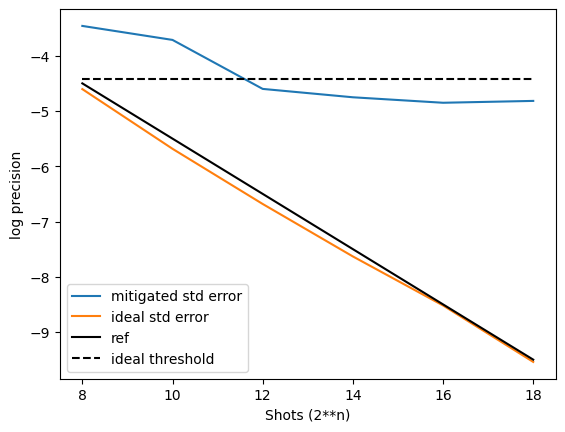

In [139]:
em_error_2 = np.sqrt(np.square(em_std_err_2) + np.square(em_bias_2))
sv_error_2 = np.sqrt(np.square(sv_std_err_2) + np.square(sv_bias_2)) #  + np.abs(sv_bias)
print(em_error)
print(sv_error)

# plt.plot(shots,np.log2(em_std_err), label="mitigated std error")
plt.plot(shots,np.log2(em_error_2), label="mitigated std error")
# plt.plot(shots,np.log2(np.abs(em_bias)), label="mitigated bias")
plt.plot(shots,np.log2(sv_error_2), label="ideal std error")
# plt.plot(shots, np.log2(np.abs(sv_bias)), label="ideal bias") 
plt.plot(shots, [np.log2(np.sqrt(1-ideal**2)/np.sqrt(2**s)) for s in shots], c = 'k', label = 'ref')
plt.hlines(np.log2(2*np.sqrt(gamma)/np.sqrt(4096)), 8, 18, linestyle = '--', color = 'k', label = 'ideal threshold')
plt.xlabel("Shots (2**n)")
plt.ylabel("log precision")
plt.legend()

This indicates that (1) we should take care in how many shots we utilize, and that (2) namely that ultimately we are limited to the variance induced by $\gamma$, and so should not exceed that number of shots.


In other words, given that we learn $\gamma$ to roughly precision $\frac{1}{\sqrt{N_\gamma}}$, our bias then is given as $\frac{1}{\sqrt{N_\gamma}}$. 

Letting $ \epsilon = \frac{\gamma}{\sqrt{M}} + \frac{1}{N_\gamma}$, we find that for $\epsilon = 2 \frac{1}{N_\gamma}$, then we have:

Why is bias $\gamma / \sqrt{N_\gamma}$ or 2? 

Bias = |(\hat \mu - \mu)|

sigma =G^2 / M


Roughly, probably bias is....bias in the estimator. Could be 

Bias = (
    sigma^2 
) = Var \gamma^2 = \frac{\gamma^2}{N}


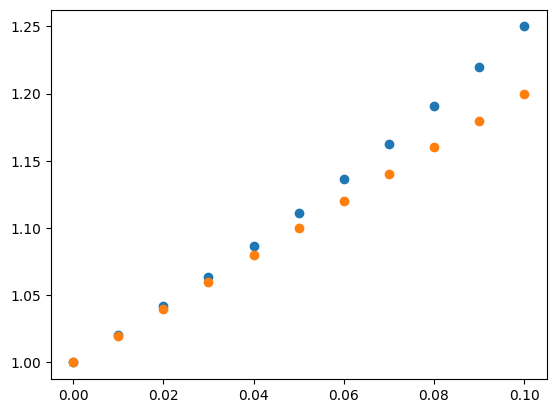

In [138]:
plt.scatter(np.linspace(0,0.1,11), np.divide(np.ones(11),np.ones(11)-2*np.linspace(0,0.1,11)))
plt.scatter(np.linspace(0,0.1,11), 1+2*np.linspace(0,0.1,11))

### Conclusion

In this 

### References 

In [ ]:
https://arxiv.org/pdf/2006.14044